# `HFSRatioModel` Tutorial

Trey V. Wenger (c) June 2025

Here we demonstrate the `HFSRatioModel`, which predicts the hyperfine spectra for two species simultaneously. The fundamental assumption is that the two species share the overall excitation temperature. Neither, one, or both of the species may assume or not assume CTEX. In the case that both species do not assume CTEX, then we assume that both species share the `CTEX_variance` hyperparameter.

In [1]:
# General imports    
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

import pytensor
print("pytensor version:", pytensor.__version__)

print("pymc version:", pm.__version__)
print("arviz version:", az.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_hfs
print("bayes_hfs version:", bayes_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pytensor version: 2.30.3
pymc version: 5.22.0
arviz version: 0.22.0dev
bayes_spec version: 1.9.0
bayes_hfs version: 1+0.gc6f9e00.dirty


## Preparing Molecule Data

Here we model the hyperfine structure of CN and $^{13}$CN transitions to the ground rotational state.

In [2]:
from bayes_hfs import get_molecule_data, supplement_molecule_data
import pickle

try:
    all_mol_data_12CN, all_mol_metadata_12CN = get_molecule_data("CN, v=0,1", fmin=100.0, fmax=200.0)
    with open("mol_data_12CN.pkl", "wb") as f:
        pickle.dump(all_mol_data_12CN, f)
    with open("mol_metadata_12CN.pkl", "wb") as f:
        pickle.dump(all_mol_metadata_12CN, f)
except:
    with open("mol_data_12CN.pkl", "rb") as f:
        all_mol_data_12CN = pickle.load(f)
    with open("mol_metadata_12CN.pkl", "rb") as f:
        all_mol_metadata_12CN = pickle.load(f)

all_mol_data_12CN.pprint_all()

    FREQ     ERR    LGINT   DR    ELO    GUP MOLWT TAG  QNFMT  Ju  Ku  vu F1u F2u F3u  Jl  Kl  vl F1l F2l F3l    name    Lab 
    MHz      MHz   nm2 MHz       1 / cm        u                                                                             
----------- ------ ------- --- --------- --- ----- ---- ----- --- --- --- --- --- --- --- --- --- --- --- --- --------- -----
 112101.656   0.05 -8.0612   2 2042.4216   2    26 5041   234   1   1   1   1  --  --   0   1   1   2  --  -- CN, v=0,1  True
 112128.989   0.05  -8.069   2 2042.4222   4    26 5041   234   1   1   1   2  --  --   0   1   1   1  --  -- CN, v=0,1  True
 112148.503   0.05 -7.9593   2 2042.4216   4    26 5041   234   1   1   1   2  --  --   0   1   1   2  --  -- CN, v=0,1  True
 112442.806   0.05 -7.9569   2 2042.4222   4    26 5041   234   1   1   2   2  --  --   0   1   1   1  --  -- CN, v=0,1  True
 112445.015   0.05 -7.5311   2 2042.4216   6    26 5041   234   1   1   2   3  --  --   0   1   1   2  --  -- CN, v=0,

In [3]:
# Keep only Kl = 0 transitions
all_mol_data_12CN = all_mol_data_12CN[all_mol_data_12CN["Kl"] == 0]

# Add GLO
all_mol_data_12CN["GLO"] = 2 * all_mol_data_12CN["F1l"]

all_mol_data_12CN.pprint_all()

    FREQ     ERR    LGINT   DR  ELO   GUP MOLWT TAG  QNFMT  Ju  Ku  vu F1u F2u F3u  Jl  Kl  vl F1l F2l F3l    name    Lab  GLO
    MHz      MHz   nm2 MHz     1 / cm       u                                                                                 
----------- ------ ------- --- ------ --- ----- ---- ----- --- --- --- --- --- --- --- --- --- --- --- --- --------- ----- ---
113123.3701 0.0058 -4.7118   2 0.0007   2    26 5041   234   1   0   1   1  --  --   0   0   1   1  --  -- CN, v=0,1 False   2
113144.1573 0.0057 -3.7989   2   -0.0   2    26 5041   234   1   0   1   1  --  --   0   0   1   2  --  -- CN, v=0,1 False   4
113170.4915 0.0039  -3.809   2 0.0007   4    26 5041   234   1   0   1   2  --  --   0   0   1   1  --  -- CN, v=0,1 False   2
113191.2787 0.0034 -3.6955   2   -0.0   4    26 5041   234   1   0   1   2  --  --   0   0   1   2  --  -- CN, v=0,1 False   4
113488.1202 0.0033 -3.6932   2 0.0007   4    26 5041   234   1   0   2   2  --  --   0   0   1   1  --  -- CN, 

In [4]:
try:
    all_mol_data_13CN, all_mol_metadata_13CN = get_molecule_data("C-13-N", fmin=100.0, fmax=200.0)
    with open("mol_data_13CN.pkl", "wb") as f:
        pickle.dump(all_mol_data_13CN, f)
    with open("mol_metadata_13CN.pkl", "wb") as f:
        pickle.dump(all_mol_metadata_13CN, f)
except:
    with open("mol_data_13CN.pkl", "rb") as f:
        all_mol_data_13CN = pickle.load(f)
    with open("mol_metadata_13CN.pkl", "rb") as f:
        all_mol_metadata_13CN = pickle.load(f)

all_mol_data_13CN.pprint_all()

    FREQ     ERR    LGINT   DR  ELO   GUP MOLWT TAG QNFMT  Ju  Ku  vu F1u F2u F3u  Jl  Kl  vl F1l F2l F3l  name   Lab 
    MHz      MHz   nm2 MHz     1 / cm       u                                                                         
----------- ------ ------- --- ------ --- ----- --- ----- --- --- --- --- --- --- --- --- --- --- --- --- ------ -----
108056.1623 0.2014  -5.598   2 0.0194   3    27 505   144   1   1   1   1  --  --   0   1   1   0  --  -- C-13-N False
108057.1556 0.1995 -5.4828   2 0.0191   1    27 505   144   1   1   1   0  --  --   0   1   1   1  --  -- C-13-N False
108062.9306 0.2014 -5.8921   2 0.0191   3    27 505   144   1   1   1   1  --  --   0   1   1   1  --  -- C-13-N False
108076.9692 0.2014 -5.2448   2 0.0187   3    27 505   144   1   1   1   1  --  --   0   1   1   2  --  -- C-13-N False
108077.2965 0.2062 -5.4626   2 0.0191   5    27 505   144   1   1   1   2  --  --   0   1   1   1  --  -- C-13-N False
108091.3352 0.2062 -5.0344   2 0.0187   5    27 

In [5]:
# Add GLO
all_mol_data_13CN["GLO"] = 2 * all_mol_data_13CN["F1l"] + 1

all_mol_data_13CN.pprint_all()

    FREQ     ERR    LGINT   DR  ELO   GUP MOLWT TAG QNFMT  Ju  Ku  vu F1u F2u F3u  Jl  Kl  vl F1l F2l F3l  name   Lab  GLO
    MHz      MHz   nm2 MHz     1 / cm       u                                                                             
----------- ------ ------- --- ------ --- ----- --- ----- --- --- --- --- --- --- --- --- --- --- --- --- ------ ----- ---
108056.1623 0.2014  -5.598   2 0.0194   3    27 505   144   1   1   1   1  --  --   0   1   1   0  --  -- C-13-N False   1
108057.1556 0.1995 -5.4828   2 0.0191   1    27 505   144   1   1   1   0  --  --   0   1   1   1  --  -- C-13-N False   3
108062.9306 0.2014 -5.8921   2 0.0191   3    27 505   144   1   1   1   1  --  --   0   1   1   1  --  -- C-13-N False   3
108076.9692 0.2014 -5.2448   2 0.0187   3    27 505   144   1   1   1   1  --  --   0   1   1   2  --  -- C-13-N False   5
108077.2965 0.2062 -5.4626   2 0.0191   5    27 505   144   1   1   1   2  --  --   0   1   1   1  --  -- C-13-N False   3
108091.3352 0.20

In [6]:
mol_data_12CN = supplement_molecule_data(all_mol_data_12CN, all_mol_metadata_12CN)
print(mol_data_12CN.keys())
print("molecular weight (Daltons):", mol_data_12CN['mol_weight'])
print("transition frequency (MHz):", mol_data_12CN['freq'])
print("Einstein A coefficient (s-1):", mol_data_12CN['Aul'])
print("Relative intensities:", mol_data_12CN['relative_int'])
print("state info:", mol_data_12CN["states"])
print("upper state index:", mol_data_12CN["state_u_idx"])
print("lower state index:", mol_data_12CN["state_l_idx"])
print("upper state degeneracy:", mol_data_12CN["Gu"])
print("lower state degeneracy:", mol_data_12CN["Gl"])

dict_keys(['mol_weight', 'freq', 'Aul', 'relative_int', 'states', 'state_u_idx', 'state_l_idx', 'Gu', 'Gl'])
molecular weight (Daltons): 26
transition frequency (MHz): [113123.3701 113144.1573 113170.4915 113191.2787 113488.1202 113490.9702
 113499.6443 113508.9074 113520.4315]
Einstein A coefficient (s-1): [1.24997446e-06 1.02301076e-05 4.99866053e-06 6.49280964e-06
 6.54458098e-06 1.15851092e-05 1.03265758e-05 5.04267116e-06
 1.26251089e-06]
Relative intensities: [0.01204927 0.09859632 0.09632981 0.12510097 0.12576526 0.33393404
 0.0992112  0.09688593 0.0121272 ]
state info: {'state': [np.str_('0 0 1 1 -- --'), np.str_('0 0 1 2 -- --'), np.str_('1 0 1 1 -- --'), np.str_('1 0 1 2 -- --'), np.str_('1 0 2 1 -- --'), np.str_('1 0 2 2 -- --'), np.str_('1 0 2 3 -- --')], 'deg': array([2, 4, 2, 4, 2, 4, 6]), 'E': array([ 1.00714381e-03, -0.00000000e+00,  5.43007265e+00,  5.43233412e+00,
        5.44813096e+00,  5.44757789e+00,  5.44670753e+00])}
upper state index: [2, 2, 3, 3, 5, 6, 4, 5, 4

In [7]:
mol_data_13CN = supplement_molecule_data(all_mol_data_13CN, all_mol_metadata_13CN)
print(mol_data_13CN.keys())
print("molecular weight (Daltons):", mol_data_13CN['mol_weight'])
print("transition frequency (MHz):", mol_data_13CN['freq'])
print("Einstein A coefficient (s-1):", mol_data_13CN['Aul'])
print("Relative intensities:", mol_data_13CN['relative_int'])
print("state info:", mol_data_13CN["states"])
print("upper state index:", mol_data_13CN["state_u_idx"])
print("lower state index:", mol_data_13CN["state_l_idx"])
print("upper state degeneracy:", mol_data_13CN["Gu"])
print("lower state degeneracy:", mol_data_13CN["Gl"])

dict_keys(['mol_weight', 'freq', 'Aul', 'relative_int', 'states', 'state_u_idx', 'state_l_idx', 'Gu', 'Gl'])
molecular weight (Daltons): 27
transition frequency (MHz): [108056.1623 108057.1556 108062.9306 108076.9692 108077.2965 108091.3352
 108406.0905 108412.862  108426.889  108631.121  108636.923  108638.212
 108643.59   108644.3456 108645.064  108651.297  108657.646  108658.948
 108780.201  108782.374  108786.982  108793.753  108796.4    108807.7879
 108986.836  109217.5674 109218.3227 109218.919 ]
Einstein A coefficient (s-1): [2.16171194e-07 8.45517260e-07 1.09830923e-07 4.87619092e-07
 1.77187921e-07 4.74996242e-07 9.16883349e-07 3.05520828e-06
 6.09953409e-06 9.32187564e-06 9.35632817e-06 3.49905729e-06
 2.48727247e-06 9.32387439e-06 2.66918119e-06 9.52389619e-06
 7.03524460e-06 3.24215072e-06 1.02222142e-05 7.54540569e-06
 5.56353117e-06 4.34687514e-06 2.67878736e-06 3.15233846e-07
 5.37667957e-08 6.73119004e-07 8.72699820e-07 7.85499700e-07]
Relative intensities: [0.00177717 

## Simulate Data

In [8]:
from bayes_spec import SpecData
from bayes_hfs import HFSRatioModel

# spectral axis definition
freq_axis_12CN_1 = np.arange(113110.0, 113200.0, 0.2) # MHz
freq_axis_12CN_2 = np.arange(113470.0, 113530.0, 0.2) # MHz
freq_axis_13CN_1 = np.arange(108620.0, 108670.0, 0.2) # MHz
freq_axis_13CN_2 = np.arange(108770.0, 108810.0, 0.2) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.001 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data_12CN_1 = noise * np.random.randn(len(freq_axis_12CN_1)) # K
brightness_data_12CN_2 = noise * np.random.randn(len(freq_axis_12CN_2)) # K
brightness_data_13CN_1 = noise * np.random.randn(len(freq_axis_13CN_1)) # K
brightness_data_13CN_2 = noise * np.random.randn(len(freq_axis_13CN_2)) # K

# CNRatioModel expects observation names to contain either "12CN" or "13CN"
observation_12CN_1 = SpecData(
    freq_axis_12CN_1,
    brightness_data_12CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_12CN_2 = SpecData(
    freq_axis_12CN_2,
    brightness_data_12CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_13CN_1 = SpecData(
    freq_axis_13CN_1,
    brightness_data_13CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
observation_13CN_2 = SpecData(
    freq_axis_13CN_2,
    brightness_data_13CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
dummy_data = {
    "12CN-1": observation_12CN_1,
    "12CN-2": observation_12CN_2,
    "13CN-1": observation_13CN_1,
    "13CN-2": observation_13CN_2,
}

The order of the molecular species passed to `HFSRatioModel` is important. The order must be the same in the following `mol_keys` variable as the `mol_data` dictionaries passed during initialization. That is, if `12CN` is the first key in `mol_keys`, then `mol_data_12CN` must also be the first dictionary passed to `HFSModel`. The inferred column density ratio is the ratio of the second species to the first species (i.e., `13CN` to `12CN` in this example).

In [9]:
# association each dataset with the related species
mol_keys = {
    "12CN": ["12CN-1", "12CN-2"],
    "13CN": ["13CN-1", "13CN-2"],
}

In [10]:
from bayes_hfs import HFSRatioModel
from bayes_hfs import physics

# Initialize and define the model
n_clouds = 3 # number of cloud components
baseline_degree = 0 # polynomial baseline degree
model = HFSRatioModel(
    mol_data_12CN, # molecular data for species 1
    mol_data_13CN, # molecular data for species 2
    mol_keys, # dataset association
    dummy_data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_Ntot1 = [13.5, 0.5], # mean and width of log10 total column density prior of first species (cm-2)
    prior_ratio = 0.1, # width of the column density ratio between the second and first species
    prior_fwhm2 = 1.0, # width of FWHM^2 prior (km2 s-2)
    prior_velocity = [-3.0, 3.0], # upper and lower limit of velocity prior (km/s)
    prior_log10_Tex_CTEX = [0.75, 0.25], # mean and width of log10 CTEX excitation temperature prior (K)
    assume_CTEX1 = False, # do not assume CTEX for the first species
    assume_CTEX2 = True, # assume CTEX for the second species for speed
    prior_log10_CTEX_variance = [-4.0, 1.0], # offset and width of log10 CTEX variance prior
    clip_weights = 1.0e-9, # clip statistical weights between [clip_weights, 1-clip_weights]
    clip_tau = -10.0, # clip optical depths below to prevent masers
    prior_fwhm_L = None, # assume Gaussian line profile
    prior_baseline_coeffs = None, # use default baseline priors
)
model.add_likelihood()

sim_params = {
    "log10_Ntot_12CN": np.array([13.8, 13.9, 14.0]),
    "ratio": np.array([1.0/65.0, 1.0/60.0, 1.0/55.0]),
    "fwhm2": np.array([1.0, 1.25, 1.5])**2.0,
    "velocity": [-2.0, 0.0, 2.5],
    "log10_Tex_CTEX": np.log10([4.46, 3.98, 3.16]),
    "log10_CTEX_variance": np.array([-1.5, -2.0, -3.0]),
    "baseline_12CN-1_norm": [0.0],
    "baseline_12CN-2_norm": [0.0],
    "baseline_13CN-1_norm": [0.0],
    "baseline_13CN-2_norm": [0.0],
}

CTEX_weights_12CN = physics.calc_stat_weight(
    model.mol1_data["states"]["deg"][None, :],
    model.mol1_data["states"]["E"][None, :],
    10.0 ** sim_params["log10_Tex_CTEX"][:, None],
).eval()

CTEX_concentration_12CN = (
    len(model.mol1_data["states"]["state"])
    * CTEX_weights_12CN
    / 10.0**sim_params["log10_CTEX_variance"][:, None]
)

from scipy.stats import dirichlet

sim_params["weights_12CN"] = np.stack([
    dirichlet(CTEX_concentration_12CN[i]).rvs()[0] for i in range(n_clouds)
])

# add derived quantities to sim_params
for key in model.cloud_deterministics:
    if key not in sim_params.keys():
        sim_params[key] = model.model[key].eval(sim_params, on_unused_input="ignore")

# Evaluate and save simulated observations
sim_12CN_1 = model.model["12CN-1"].eval(sim_params, on_unused_input="ignore")
sim_12CN_2 = model.model["12CN-2"].eval(sim_params, on_unused_input="ignore")
sim_13CN_1 = model.model["13CN-1"].eval(sim_params, on_unused_input="ignore")
sim_13CN_2 = model.model["13CN-2"].eval(sim_params, on_unused_input="ignore")

# pack simulated data
observation_12CN_1 = SpecData(
    freq_axis_12CN_1,
    sim_12CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_12CN_2 = SpecData(
    freq_axis_12CN_2,
    sim_12CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_13CN_1 = SpecData(
    freq_axis_13CN_1,
    sim_13CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
observation_13CN_2 = SpecData(
    freq_axis_13CN_2,
    sim_13CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
data = {
    "12CN-1": observation_12CN_1,
    "12CN-2": observation_12CN_2,
    "13CN-1": observation_13CN_1,
    "13CN-2": observation_13CN_2,
}

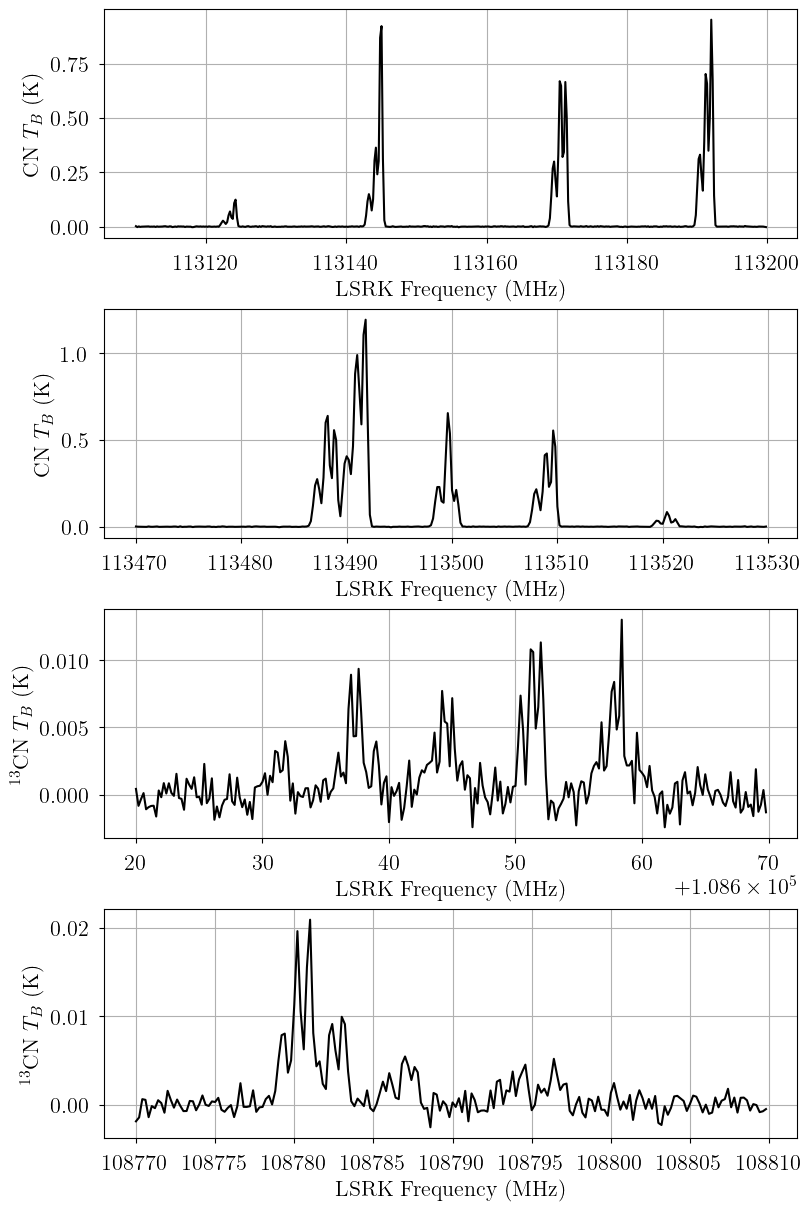

In [11]:
# Plot the simulated data
fig, axes = plt.subplots(4, layout="constrained", figsize=(8, 12))
for i, dataset in enumerate(data.values()):
    axes[i].plot(dataset.spectral, dataset.brightness, 'k-')
    axes[i].set_ylabel(dataset.ylabel)
    _ = axes[i].set_xlabel(dataset.xlabel)

In [12]:
sim_params

{'log10_Ntot_12CN': array([13.8, 13.9, 14. ]),
 'ratio': array([0.01538462, 0.01666667, 0.01818182]),
 'fwhm2': array([1.    , 1.5625, 2.25  ]),
 'velocity': [-2.0, 0.0, 2.5],
 'log10_Tex_CTEX': array([0.64933486, 0.59988307, 0.49968708]),
 'log10_CTEX_variance': array([-1.5, -2. , -3. ]),
 'baseline_12CN-1_norm': [0.0],
 'baseline_12CN-2_norm': [0.0],
 'baseline_13CN-1_norm': [0.0],
 'baseline_13CN-2_norm': [0.0],
 'weights_12CN': array([[0.18217207, 0.3420491 , 0.0549568 , 0.1090344 , 0.05406404,
         0.10595788, 0.15176571],
        [0.18558518, 0.37959808, 0.04676937, 0.09318156, 0.05182396,
         0.09195015, 0.1510917 ],
        [0.21533183, 0.43479939, 0.03894158, 0.07836171, 0.03816636,
         0.07787778, 0.11652136]]),
 'log10_Ntot_13CN': array([11.98708664, 12.12184875, 12.25963731]),
 'CTEX_weights_12CN': array([[1.99954842, 4.        , 0.59193533, 1.18327051, 0.58954346,
         1.17923313, 1.76919492],
        [1.99949396, 4.        , 0.51109864, 1.02161662, 0.508

## Model Definition

In [13]:
# Initialize and define the model
mol_keys_rev = {"13CN": mol_keys["13CN"], "12CN": mol_keys["12CN"]}
model = HFSRatioModel(
    mol_data_12CN, # molecular data for species 1
    mol_data_13CN, # molecular data for species 2
    mol_keys, # dataset association
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_Ntot1 = [13.5, 0.5], # mean and width of log10 total column density prior of first species (cm-2)
    prior_ratio = 0.1, # width of the column density ratio between the second and first species
    prior_fwhm2 = 1.0, # width of FWHM^2 prior (km2 s-2)
    prior_velocity = [-3.0, 3.0], # upper and lower limit of velocity prior (km/s)
    prior_log10_Tex_CTEX = [0.75, 0.25], # mean and width of log10 CTEX excitation temperature prior (K)
    assume_CTEX1 = False, # do not assume CTEX for the first species
    assume_CTEX2 = True, # assume CTEX for the second species for efficiency
    prior_log10_CTEX_variance = [-4.0, 1.0], # offset and width of log10 CTEX variance prior
    clip_weights = 1.0e-9, # clip statistical weights between [clip_weights, 1-clip_weights]
    clip_tau = -10.0, # clip optical depths below to prevent masers
    prior_fwhm_L = None, # assume Gaussian line profile
    prior_baseline_coeffs = None, # use default baseline priors
)
model.add_likelihood()

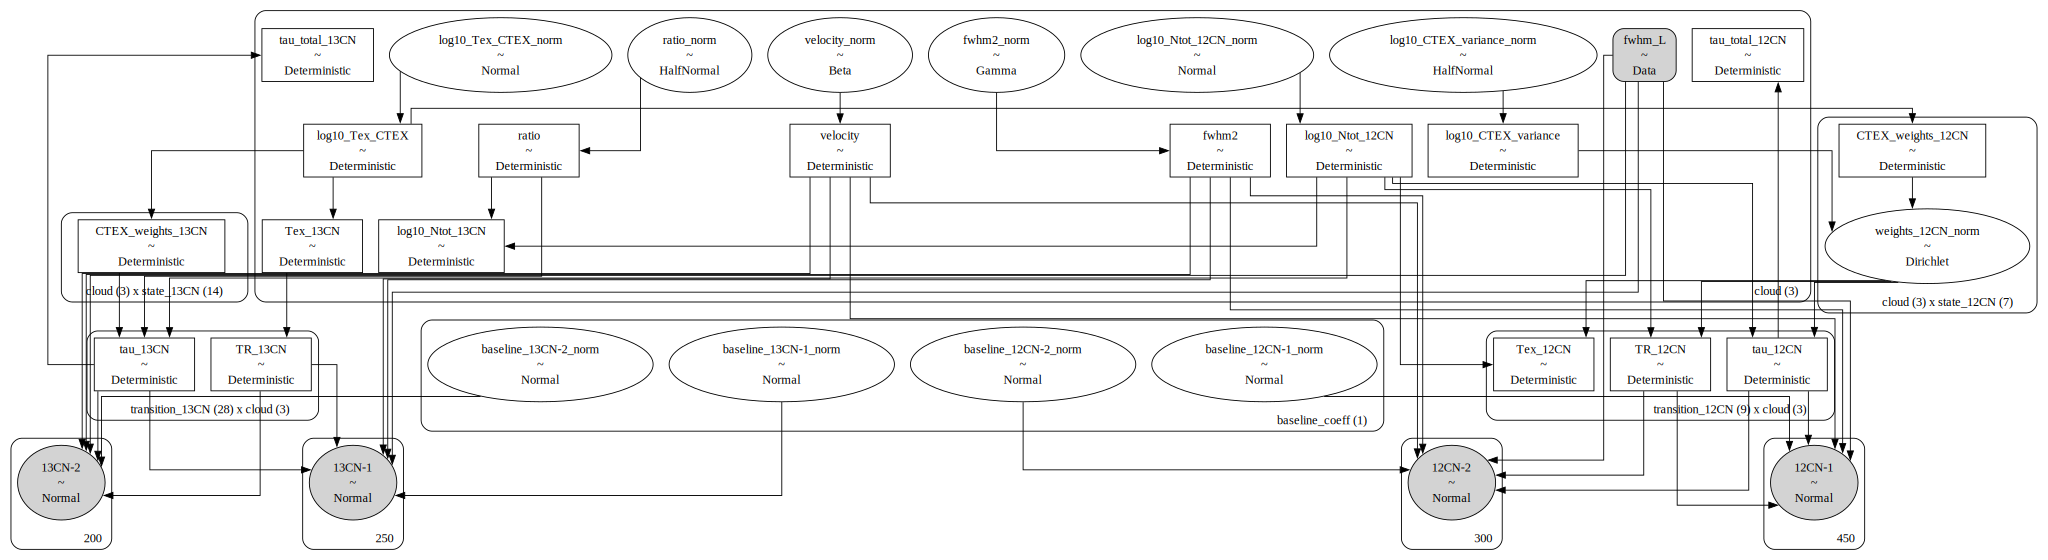

In [14]:
# Plot model graph
model.graph().render('hfs_ratio_model', format='png')
model.graph()

In [15]:
# model string representation
print(model.model.str_repr())

    baseline_12CN-1_norm ~ Normal(0, 1)
    baseline_12CN-2_norm ~ Normal(0, 1)
    baseline_13CN-1_norm ~ Normal(0, 1)
    baseline_13CN-2_norm ~ Normal(0, 1)
    log10_Ntot_12CN_norm ~ Normal(0, 1)
              ratio_norm ~ HalfNormal(0, 1)
              fwhm2_norm ~ Gamma(0.5, f())
           velocity_norm ~ Beta(2, 2)
     log10_Tex_CTEX_norm ~ Normal(0, 1)
log10_CTEX_variance_norm ~ HalfNormal(0, 1)
       weights_12CN_norm ~ Dirichlet(f(log10_CTEX_variance_norm, log10_Tex_CTEX_norm))
         log10_Ntot_12CN ~ Deterministic(f(log10_Ntot_12CN_norm))
                   ratio ~ Deterministic(f(ratio_norm))
                   fwhm2 ~ Deterministic(f(fwhm2_norm))
                velocity ~ Deterministic(f(velocity_norm))
          log10_Tex_CTEX ~ Deterministic(f(log10_Tex_CTEX_norm))
         log10_Ntot_13CN ~ Deterministic(f(ratio_norm, log10_Ntot_12CN_norm))
     log10_CTEX_variance ~ Deterministic(f(log10_CTEX_variance_norm))
       CTEX_weights_12CN ~ Deterministic(f(log10_Tex_C

Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2, baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN-1_norm, baseline_13CN-2_norm, fwhm2_norm, log10_CTEX_variance_norm, log10_Ntot_12CN_norm, log10_Tex_CTEX_norm, ratio_norm, velocity_norm, weights_12CN_norm]


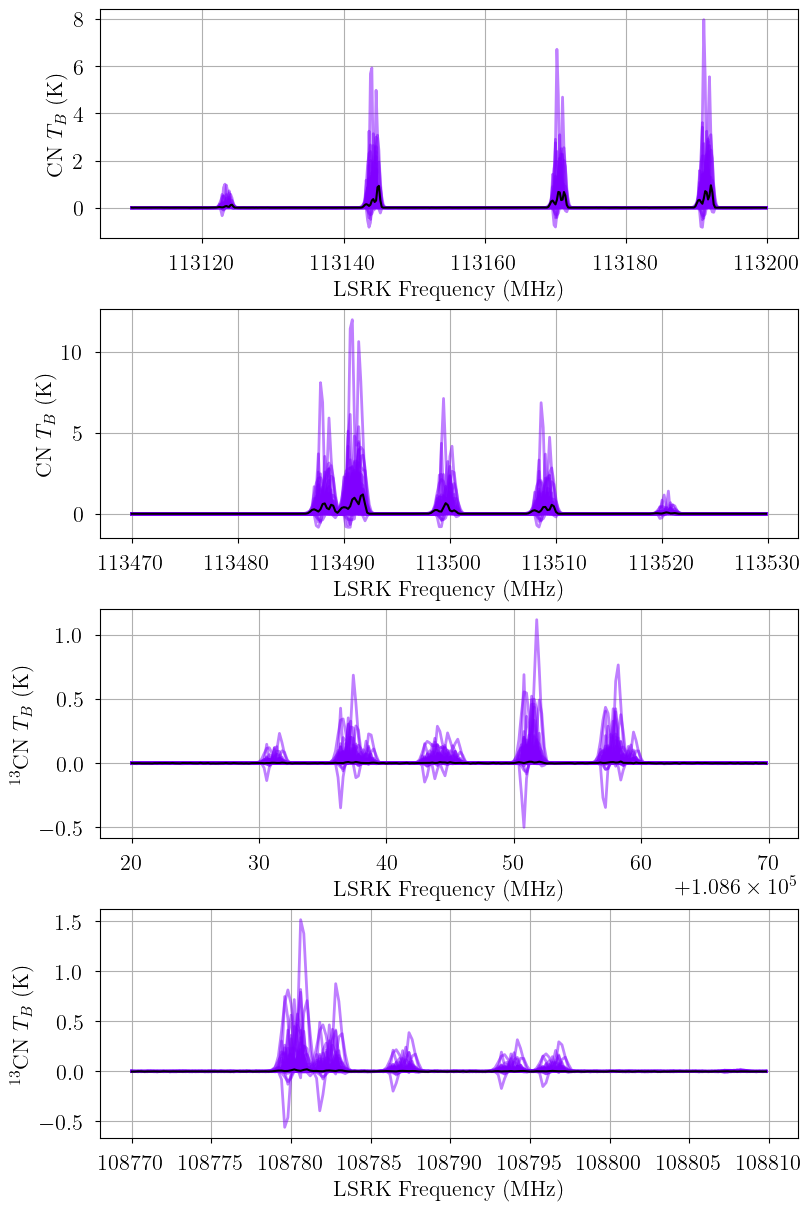

In [16]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=1000,  # prior predictive samples
)
axes = plot_predictive(model.data, prior.prior_predictive.sel(draw=slice(None, None, 20)))
axes.ravel()[0].figure.set_size_inches(8, 12)

In [17]:
print(model.cloud_freeRVs)
print(model.cloud_deterministics)

['log10_Ntot_12CN_norm', 'ratio_norm', 'fwhm2_norm', 'velocity_norm', 'log10_Tex_CTEX_norm', 'log10_CTEX_variance_norm', 'weights_12CN_norm']
['log10_Ntot_12CN', 'ratio', 'fwhm2', 'velocity', 'log10_Tex_CTEX', 'log10_Ntot_13CN', 'log10_CTEX_variance', 'CTEX_weights_12CN', 'Tex_12CN', 'tau_12CN', 'tau_total_12CN', 'TR_12CN', 'CTEX_weights_13CN', 'Tex_13CN', 'tau_13CN', 'tau_total_13CN', 'TR_13CN']


['log10_Ntot_12CN', 'ratio', 'fwhm2', 'velocity', 'log10_Tex_CTEX', 'log10_Ntot_13CN', 'log10_CTEX_variance', 'tau_total_12CN', 'Tex_13CN', 'tau_total_13CN']


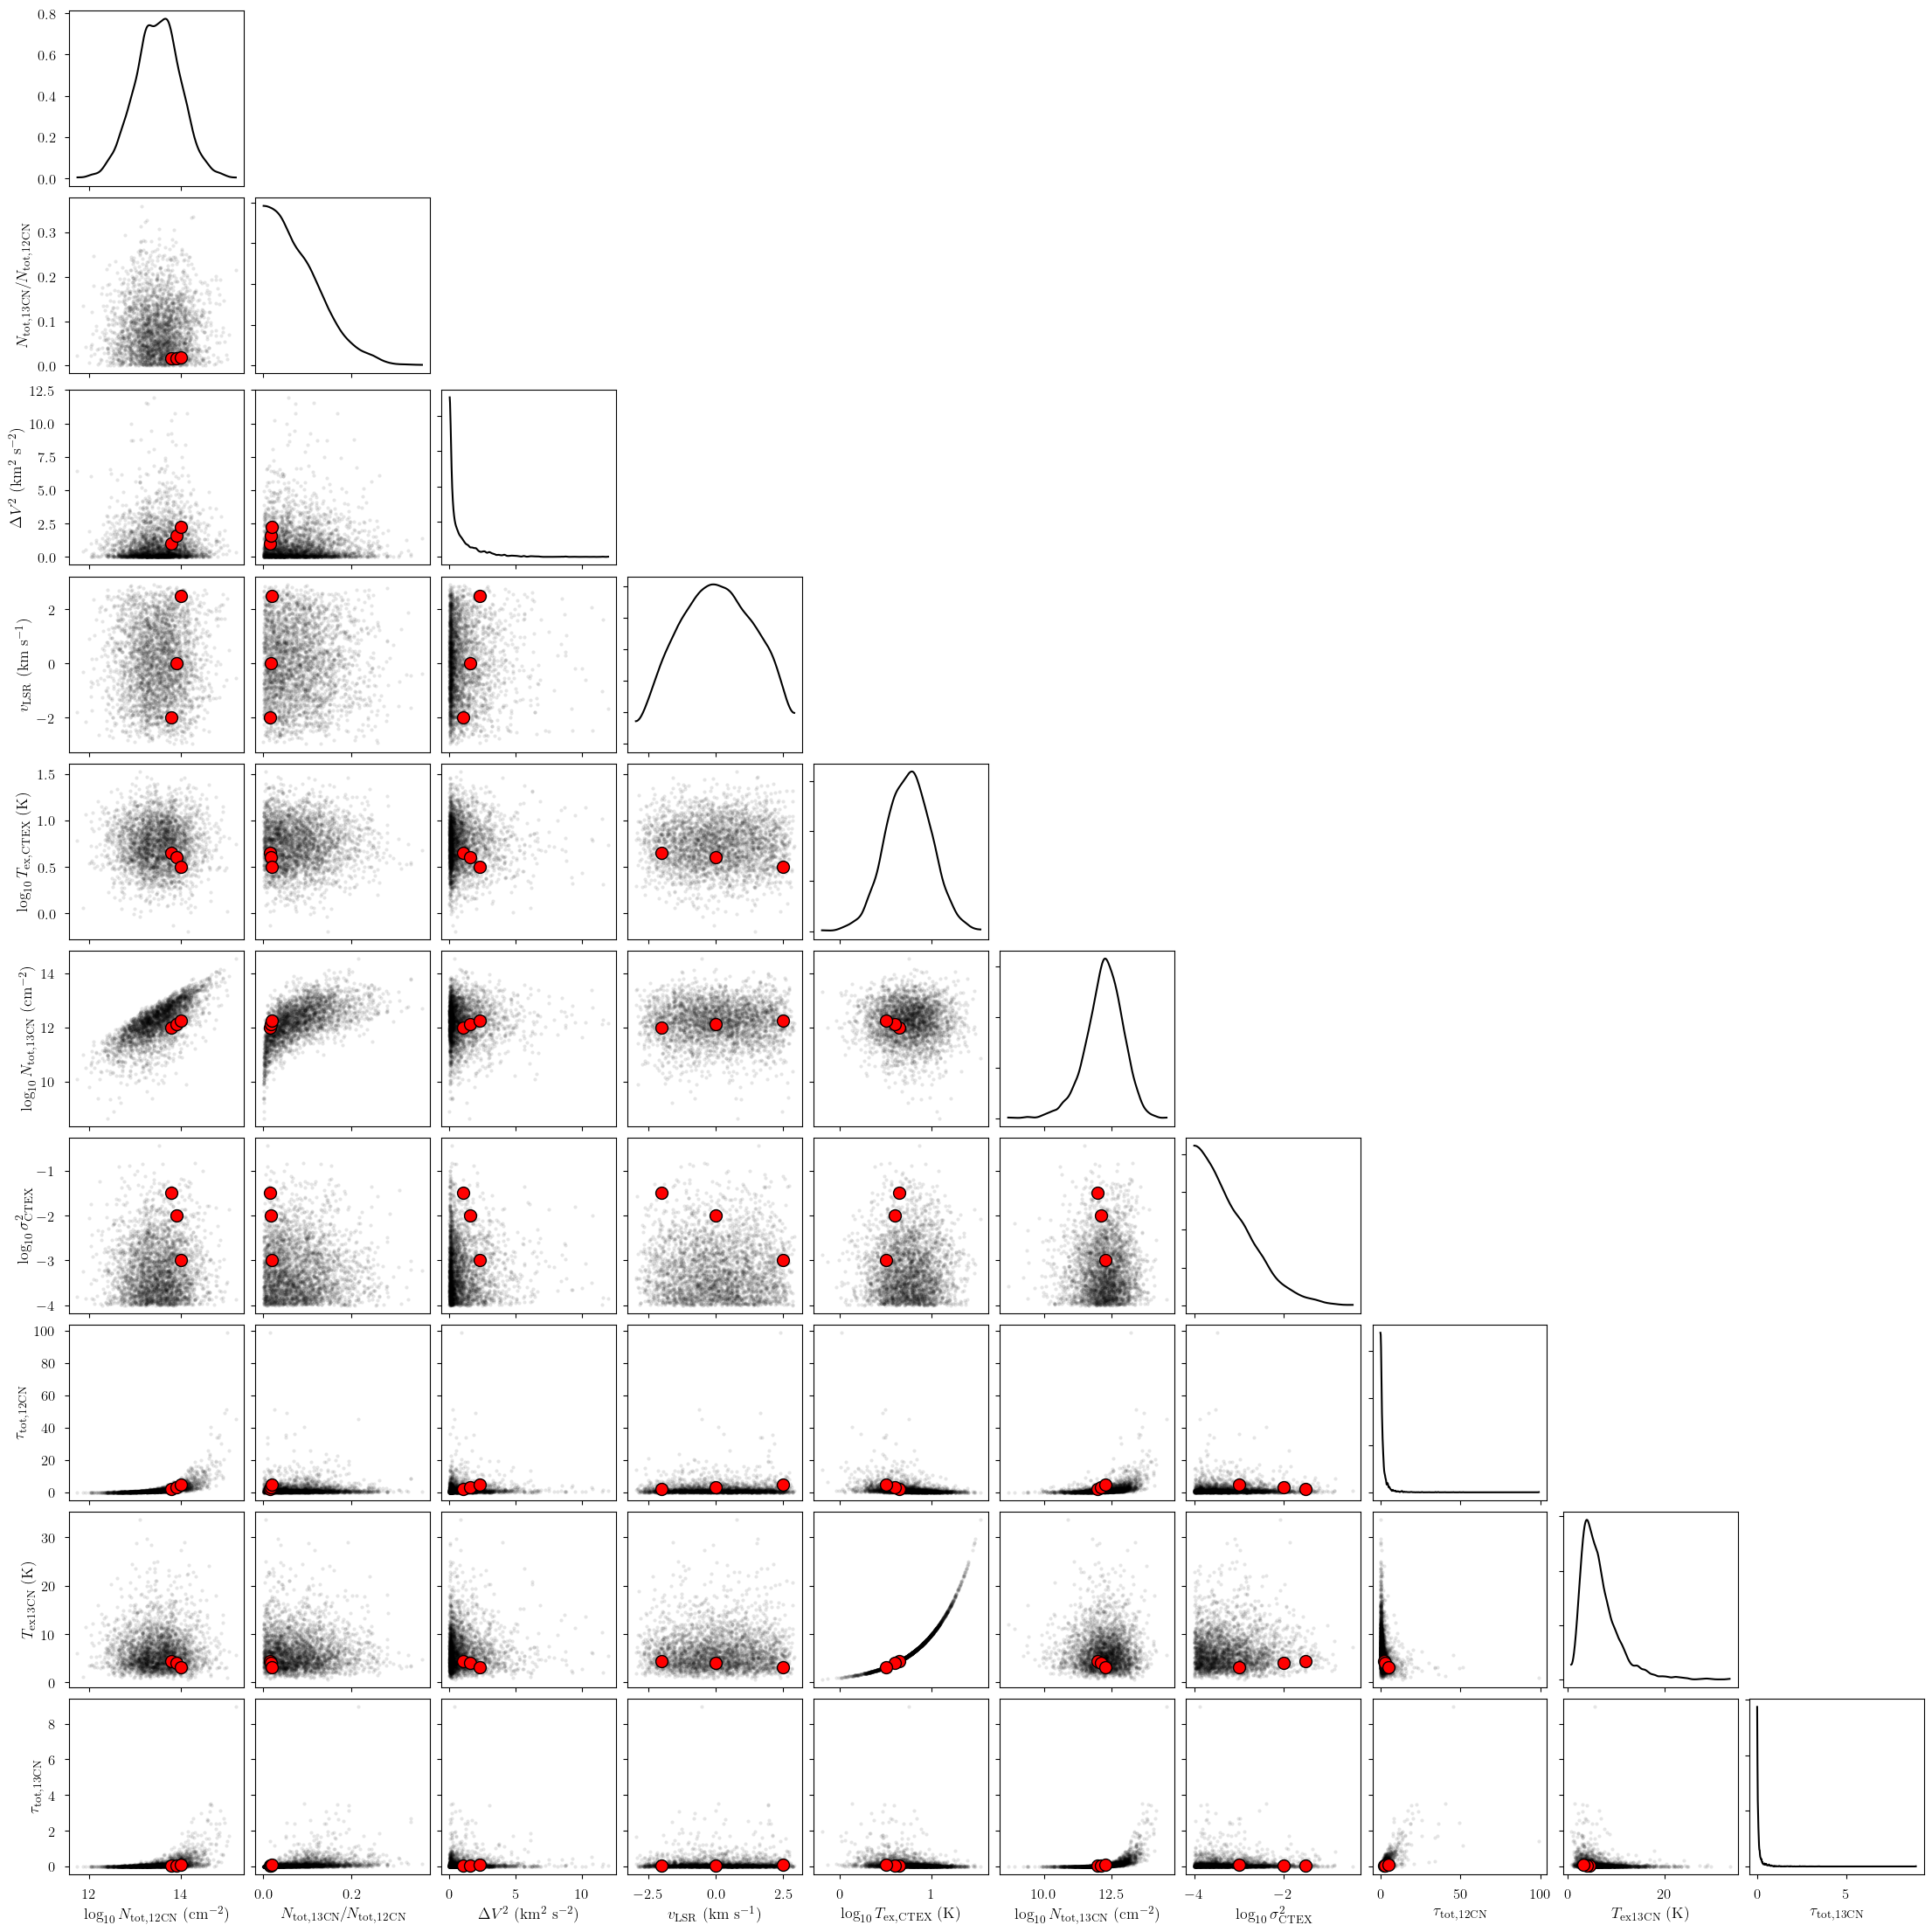

In [18]:
from bayes_spec.plots import plot_pair

var_names = [
    param for param in model.cloud_deterministics + [p for p in model.cloud_freeRVs if "_norm" not in p]
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]))
]
print(var_names)
_ = plot_pair(
    prior.prior, # samples
    var_names, # var_names to plot
    combine_dims=["cloud"], # concatenate clouds
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=sim_params, # truths
)

## Variational Inference

In [19]:
start = time.time()
model.fit(
    n = 1_000_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.01, # VI absolute convergence threshold
    learning_rate = 0.001, # VI learning rate
    start = {"velocity_norm": np.linspace(0.1, 0.9, n_clouds)},
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 52400
Interrupted at 52,399 [5%]: Average Loss = 5.5843e+28


Adding log-likelihood to trace


Output()

Runtime: 19.86 minutes


In [20]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
/home/twenger/miniforge3/envs/bayes_spec-dev/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/home/twenger/miniforge3/envs/bayes_spec-dev/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/home/twenger/miniforge3/envs/bayes_spec-dev/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/home/twenger/miniforge3/envs/bayes_spec-dev/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/home/twenger/miniforge3/envs/bayes_spec-dev/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: inva

mean     sd  hdi_3%  hdi_97%  \
baseline_12CN-1_norm[0]               0.036  0.050  -0.048    0.139   
baseline_12CN-2_norm[0]               0.024  0.060  -0.082    0.145   
baseline_13CN-1_norm[0]              -0.021  0.064  -0.147    0.098   
baseline_13CN-2_norm[0]               0.055  0.073  -0.090    0.181   
log10_Ntot_12CN_norm[0]               0.597  0.000   0.596    0.597   
log10_Ntot_12CN_norm[1]               0.797  0.000   0.796    0.798   
log10_Ntot_12CN_norm[2]               0.986  0.001   0.985    0.989   
log10_Tex_CTEX_norm[0]               -0.316  0.030  -0.375   -0.262   
log10_Tex_CTEX_norm[1]               -0.461  0.024  -0.510   -0.419   
log10_Tex_CTEX_norm[2]               -0.934  0.017  -0.963   -0.901   
ratio_norm[0]                         0.141  0.004   0.135    0.149   
ratio_norm[1]                         0.140  0.004   0.134    0.147   
ratio_norm[2]                         0.138  0.007   0.124    0.151   
fwhm2_norm[0]                         1.003  0.001   1.001    1.005   
fwhm2_norm[1]                         1.563  0.002   1.559    1.567   
fwhm2_norm[2]                         2.245  0.006   2.233    2.256   
velocity_norm[0]                      0.167  0.000   0.167    0.167   
velocity_norm[1]                      0.500  0.000   0.500    0.500   
velocity_norm[2]                      0.917  0.000   0.916    0.917   
log10_CTEX_variance_norm[0]           2.434  0.227   2.046    2.880   
log10_CTEX_variance_norm[1]           1.931  0.219   1.568    2.375   
log10_CTEX_variance_norm[2]           1.206  0.242   0.796    1.669   
weights_12CN_norm[0, 0 0 1 1 -- --]   0.190  0.000   0.190    0.190   
weights_12CN_norm[0, 0 0 1 2 -- --]   0.329  0.000   0.329    0.329   
weights_12CN_norm[0, 1 0 1 1 -- --]   0.070  0.000   0.070    0.070   
weights_12CN_norm[0, 1 0 1 2 -- --]   0.121  0.000   0.121    0.121   
weights_12CN_norm[0, 1 0 2 1 -- --]   0.036  0.000   0.036    0.036   
weights_12CN_norm[0, 1 0 2 2 -- --]   0.102  0.000   0.102    0.102   
weights_12CN_norm[0, 1 0 2 3 -- --]   0.151  0.000   0.151    0.151   
weights_12CN_norm[1, 0 0 1 1 -- --]   0.162  0.000   0.162    0.162   
weights_12CN_norm[1, 0 0 1 2 -- --]   0.380  0.000   0.380    0.380   
weights_12CN_norm[1, 1 0 1 1 -- --]   0.044  0.000   0.044    0.044   
weights_12CN_norm[1, 1 0 1 2 -- --]   0.112  0.000   0.112    0.112   
weights_12CN_norm[1, 1 0 2 1 -- --]   0.053  0.000   0.053    0.053   
weights_12CN_norm[1, 1 0 2 2 -- --]   0.097  0.000   0.097    0.097   
weights_12CN_norm[1, 1 0 2 3 -- --]   0.152  0.000   0.152    0.152   
weights_12CN_norm[2, 0 0 1 1 -- --]   0.208  0.000   0.208    0.209   
weights_12CN_norm[2, 0 0 1 2 -- --]   0.427  0.000   0.427    0.428   
weights_12CN_norm[2, 1 0 1 1 -- --]   0.036  0.000   0.036    0.036   
weights_12CN_norm[2, 1 0 1 2 -- --]   0.087  0.000   0.087    0.087   
weights_12CN_norm[2, 1 0 2 1 -- --]   0.040  0.000   0.040    0.040   
weights_12CN_norm[2, 1 0 2 2 -- --]   0.079  0.000   0.079    0.080   
weights_12CN_norm[2, 1 0 2 3 -- --]   0.122  0.000   0.121    0.122   
log10_Ntot_12CN[0]                   13.798  0.000  13.798   13.799   
log10_Ntot_12CN[1]                   13.898  0.000  13.898   13.899   
log10_Ntot_12CN[2]                   13.993  0.001  13.992   13.994   
ratio[0]                              0.014  0.000   0.013    0.015   
ratio[1]                              0.014  0.000   0.013    0.015   
ratio[2]                              0.014  0.001   0.012    0.015   
fwhm2[0]                              1.003  0.001   1.001    1.005   
fwhm2[1]                              1.563  0.002   1.559    1.567   
fwhm2[2]                              2.245  0.006   2.233    2.256   
velocity[0]                          -2.000  0.000  -2.001   -2.000   
velocity[1]                           0.000  0.000  -0.000    0.001   
velocity[2]                           2.500  0.001   2.499    2.502   
log10_Tex_CTEX[0]                     0.671  0.008   0.656    0

Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2]


Output()

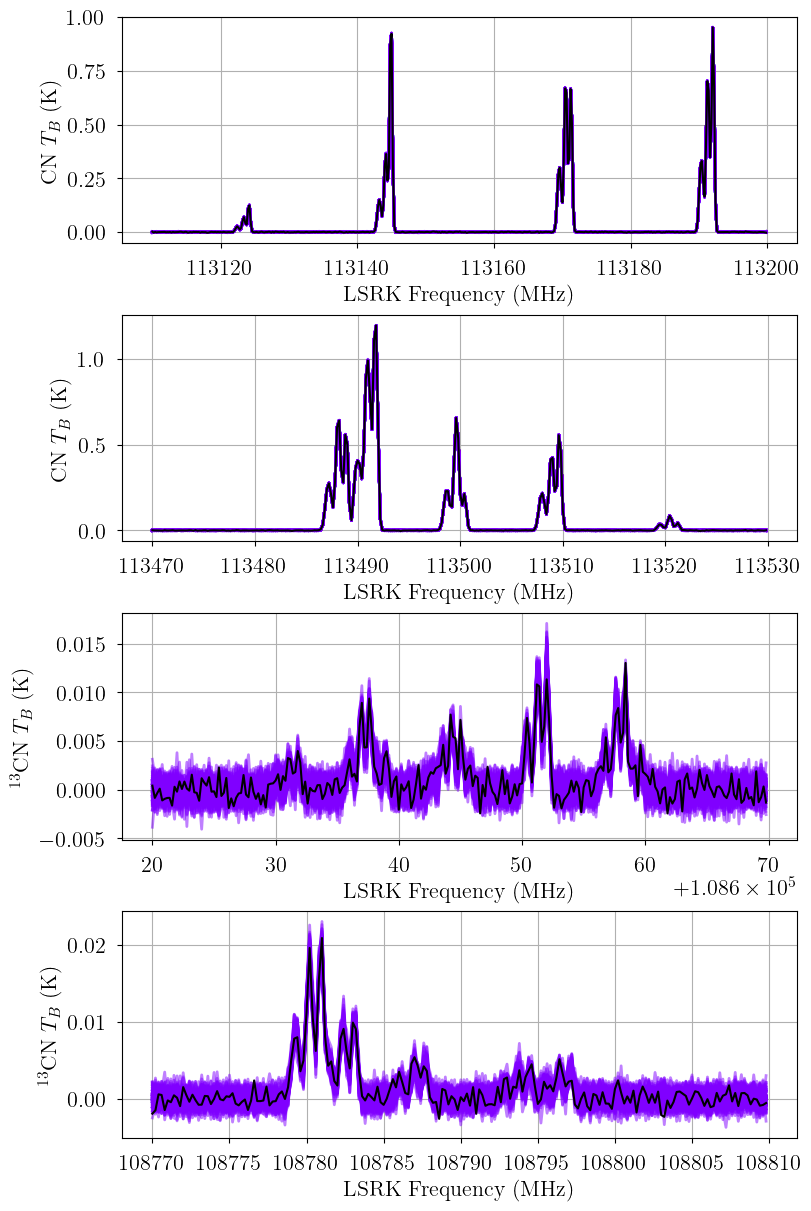

In [21]:
posterior = model.sample_posterior_predictive(
    thin=10, # keep one in {thin} posterior samples
)
axes = plot_predictive(model.data, posterior.posterior_predictive)
axes.ravel()[0].figure.set_size_inches(8, 12)

## Posterior Sampling: MCMC

In [22]:
start = time.time()
model.sample(
    init="advi+adapt_diag",  # initialization strategy
    tune=1000,  # tuning samples
    draws=1000,  # posterior samples
    chains=8,  # number of independent chains
    cores=8,  # number of parallel chains
    init_kwargs={
        "rel_tolerance": 0.01,
        "abs_tolerance": 0.01,
        "learning_rate": 0.001,
        "start": {"velocity_norm": np.linspace(0.1, 0.9, n_clouds)},
    },  # VI initialization arguments
    nuts_kwargs={"target_accept": 0.9},  # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 52400
Interrupted at 52,399 [5%]: Average Loss = 5.5843e+28
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN-1_norm, baseline_13CN-2_norm, log10_Ntot_12CN_norm, ratio_norm, fwhm2_norm, velocity_norm, log10_Tex_CTEX_norm, log10_CTEX_variance_norm, weights_12CN_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 944 seconds.


Adding log-likelihood to trace


Output()

Runtime: 36.27 minutes


In [23]:
model.solve(
    init_params="random_from_data", # GMM initialization strategy
    n_init=10, # number of GMM initilizations
    max_iter=1_000, # maximum number of GMM iterations
    kl_div_threshold=0.1, # covergence threshold
)

GMM converged to unique solution


In [24]:
print("solutions:", model.solutions)

pm.summary(model.trace.solution_0)

solutions: [0]


/home/twenger/miniforge3/envs/bayes_spec-dev/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/twenger/miniforge3/envs/bayes_spec-dev/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/home/twenger/miniforge3/envs/bayes_spec-dev/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/twenger/miniforge3/envs/bayes_spec-dev/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/home/twenger/miniforge3/envs/bayes_spec-dev/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeW

mean     sd  hdi_3%  hdi_97%  \
baseline_12CN-1_norm[0]               0.036  0.050  -0.058    0.130   
baseline_12CN-2_norm[0]               0.024  0.065  -0.098    0.145   
baseline_13CN-1_norm[0]              -0.028  0.067  -0.156    0.096   
baseline_13CN-2_norm[0]               0.050  0.074  -0.089    0.186   
log10_Ntot_12CN_norm[0]               0.597  0.005   0.588    0.606   
log10_Ntot_12CN_norm[1]               0.797  0.005   0.788    0.805   
log10_Ntot_12CN_norm[2]               0.987  0.009   0.971    1.003   
log10_Tex_CTEX_norm[0]               -0.342  0.163  -0.644   -0.030   
log10_Tex_CTEX_norm[1]               -0.463  0.095  -0.633   -0.286   
log10_Tex_CTEX_norm[2]               -0.934  0.034  -0.999   -0.872   
ratio_norm[0]                         0.148  0.024   0.112    0.192   
ratio_norm[1]                         0.142  0.015   0.115    0.168   
ratio_norm[2]                         0.140  0.016   0.111    0.168   
fwhm2_norm[0]                         1.002  0.002   0.998    1.007   
fwhm2_norm[1]                         1.564  0.004   1.555    1.572   
fwhm2_norm[2]                         2.246  0.011   2.226    2.267   
velocity_norm[0]                      0.167  0.000   0.167    0.167   
velocity_norm[1]                      0.500  0.000   0.500    0.500   
velocity_norm[2]                      0.917  0.000   0.916    0.917   
log10_CTEX_variance_norm[0]           2.472  0.237   2.033    2.914   
log10_CTEX_variance_norm[1]           1.999  0.247   1.558    2.466   
log10_CTEX_variance_norm[2]           1.255  0.266   0.782    1.751   
weights_12CN_norm[0, 0 0 1 1 -- --]   0.190  0.000   0.190    0.191   
weights_12CN_norm[0, 0 0 1 2 -- --]   0.329  0.001   0.328    0.330   
weights_12CN_norm[0, 1 0 1 1 -- --]   0.070  0.000   0.070    0.071   
weights_12CN_norm[0, 1 0 1 2 -- --]   0.121  0.000   0.121    0.121   
weights_12CN_norm[0, 1 0 2 1 -- --]   0.036  0.000   0.036    0.037   
weights_12CN_norm[0, 1 0 2 2 -- --]   0.102  0.000   0.102    0.102   
weights_12CN_norm[0, 1 0 2 3 -- --]   0.151  0.000   0.151    0.151   
weights_12CN_norm[1, 0 0 1 1 -- --]   0.162  0.000   0.162    0.163   
weights_12CN_norm[1, 0 0 1 2 -- --]   0.380  0.000   0.379    0.380   
weights_12CN_norm[1, 1 0 1 1 -- --]   0.044  0.000   0.044    0.044   
weights_12CN_norm[1, 1 0 1 2 -- --]   0.112  0.000   0.112    0.112   
weights_12CN_norm[1, 1 0 2 1 -- --]   0.053  0.000   0.053    0.053   
weights_12CN_norm[1, 1 0 2 2 -- --]   0.097  0.000   0.096    0.097   
weights_12CN_norm[1, 1 0 2 3 -- --]   0.152  0.000   0.152    0.153   
weights_12CN_norm[2, 0 0 1 1 -- --]   0.208  0.000   0.208    0.209   
weights_12CN_norm[2, 0 0 1 2 -- --]   0.427  0.000   0.427    0.428   
weights_12CN_norm[2, 1 0 1 1 -- --]   0.036  0.000   0.036    0.036   
weights_12CN_norm[2, 1 0 1 2 -- --]   0.087  0.000   0.087    0.087   
weights_12CN_norm[2, 1 0 2 1 -- --]   0.040  0.000   0.040    0.040   
weights_12CN_norm[2, 1 0 2 2 -- --]   0.079  0.000   0.079    0.080   
weights_12CN_norm[2, 1 0 2 3 -- --]   0.122  0.000   0.121    0.122   
log10_Ntot_12CN[0]                   13.799  0.002  13.794   13.803   
log10_Ntot_12CN[1]                   13.898  0.002  13.894   13.903   
log10_Ntot_12CN[2]                   13.993  0.004  13.985   14.002   
ratio[0]                              0.015  0.002   0.011    0.019   
ratio[1]                              0.014  0.001   0.012    0.017   
ratio[2]                              0.014  0.002   0.011    0.017   
fwhm2[0]                              1.002  0.002   0.998    1.007   
fwhm2[1]                              1.564  0.004   1.555    1.572   
fwhm2[2]                              2.246  0.011   2.226    2.267   
velocity[0]                          -2.000  0.000  -2.001   -2.000   
velocity[1]                           0.000  0.000  -0.001    0.001   
velocity[2]                           2.501  0.001   2.499    2.502   
log10_Tex_CTEX[0]                     0.664  0.041   0.589    0

Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2]


Output()

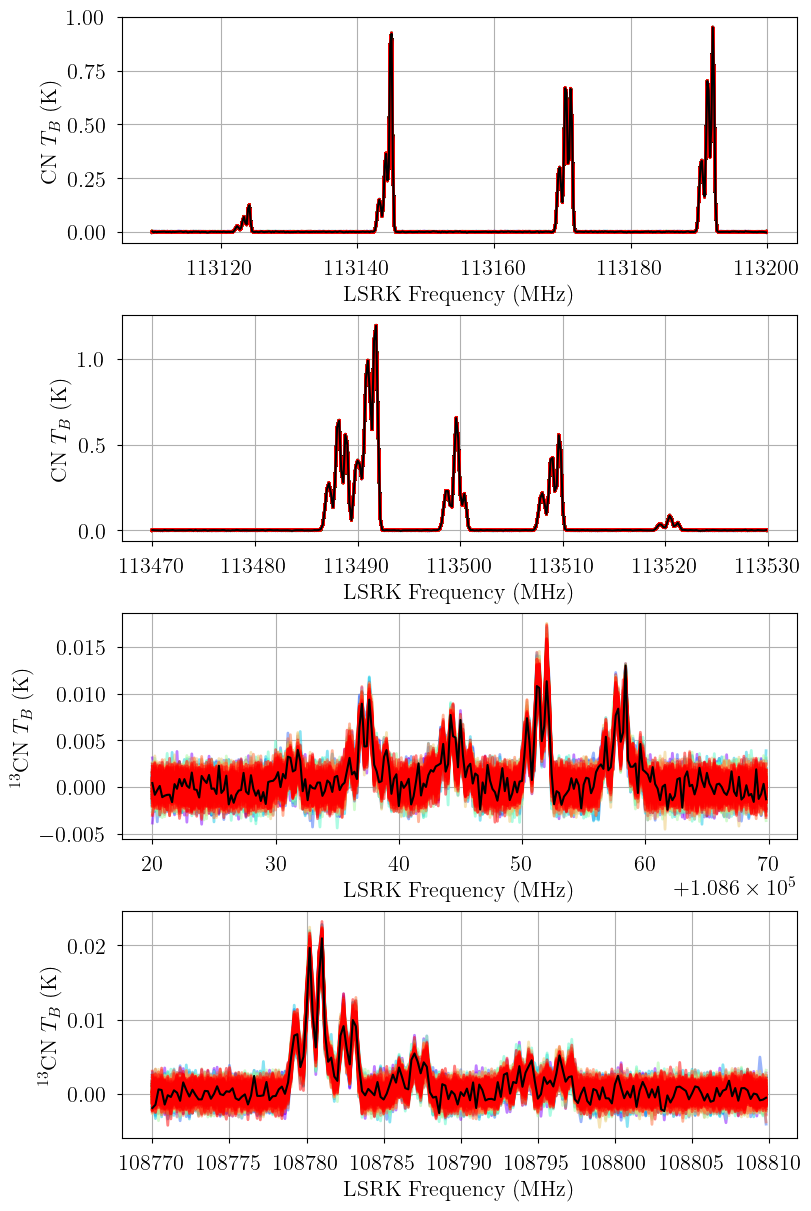

In [25]:
posterior = model.sample_posterior_predictive(
    thin=10, # keep one in {thin} posterior samples
)
axes = plot_predictive(model.data, posterior.posterior_predictive)
axes.ravel()[0].figure.set_size_inches(8, 12)

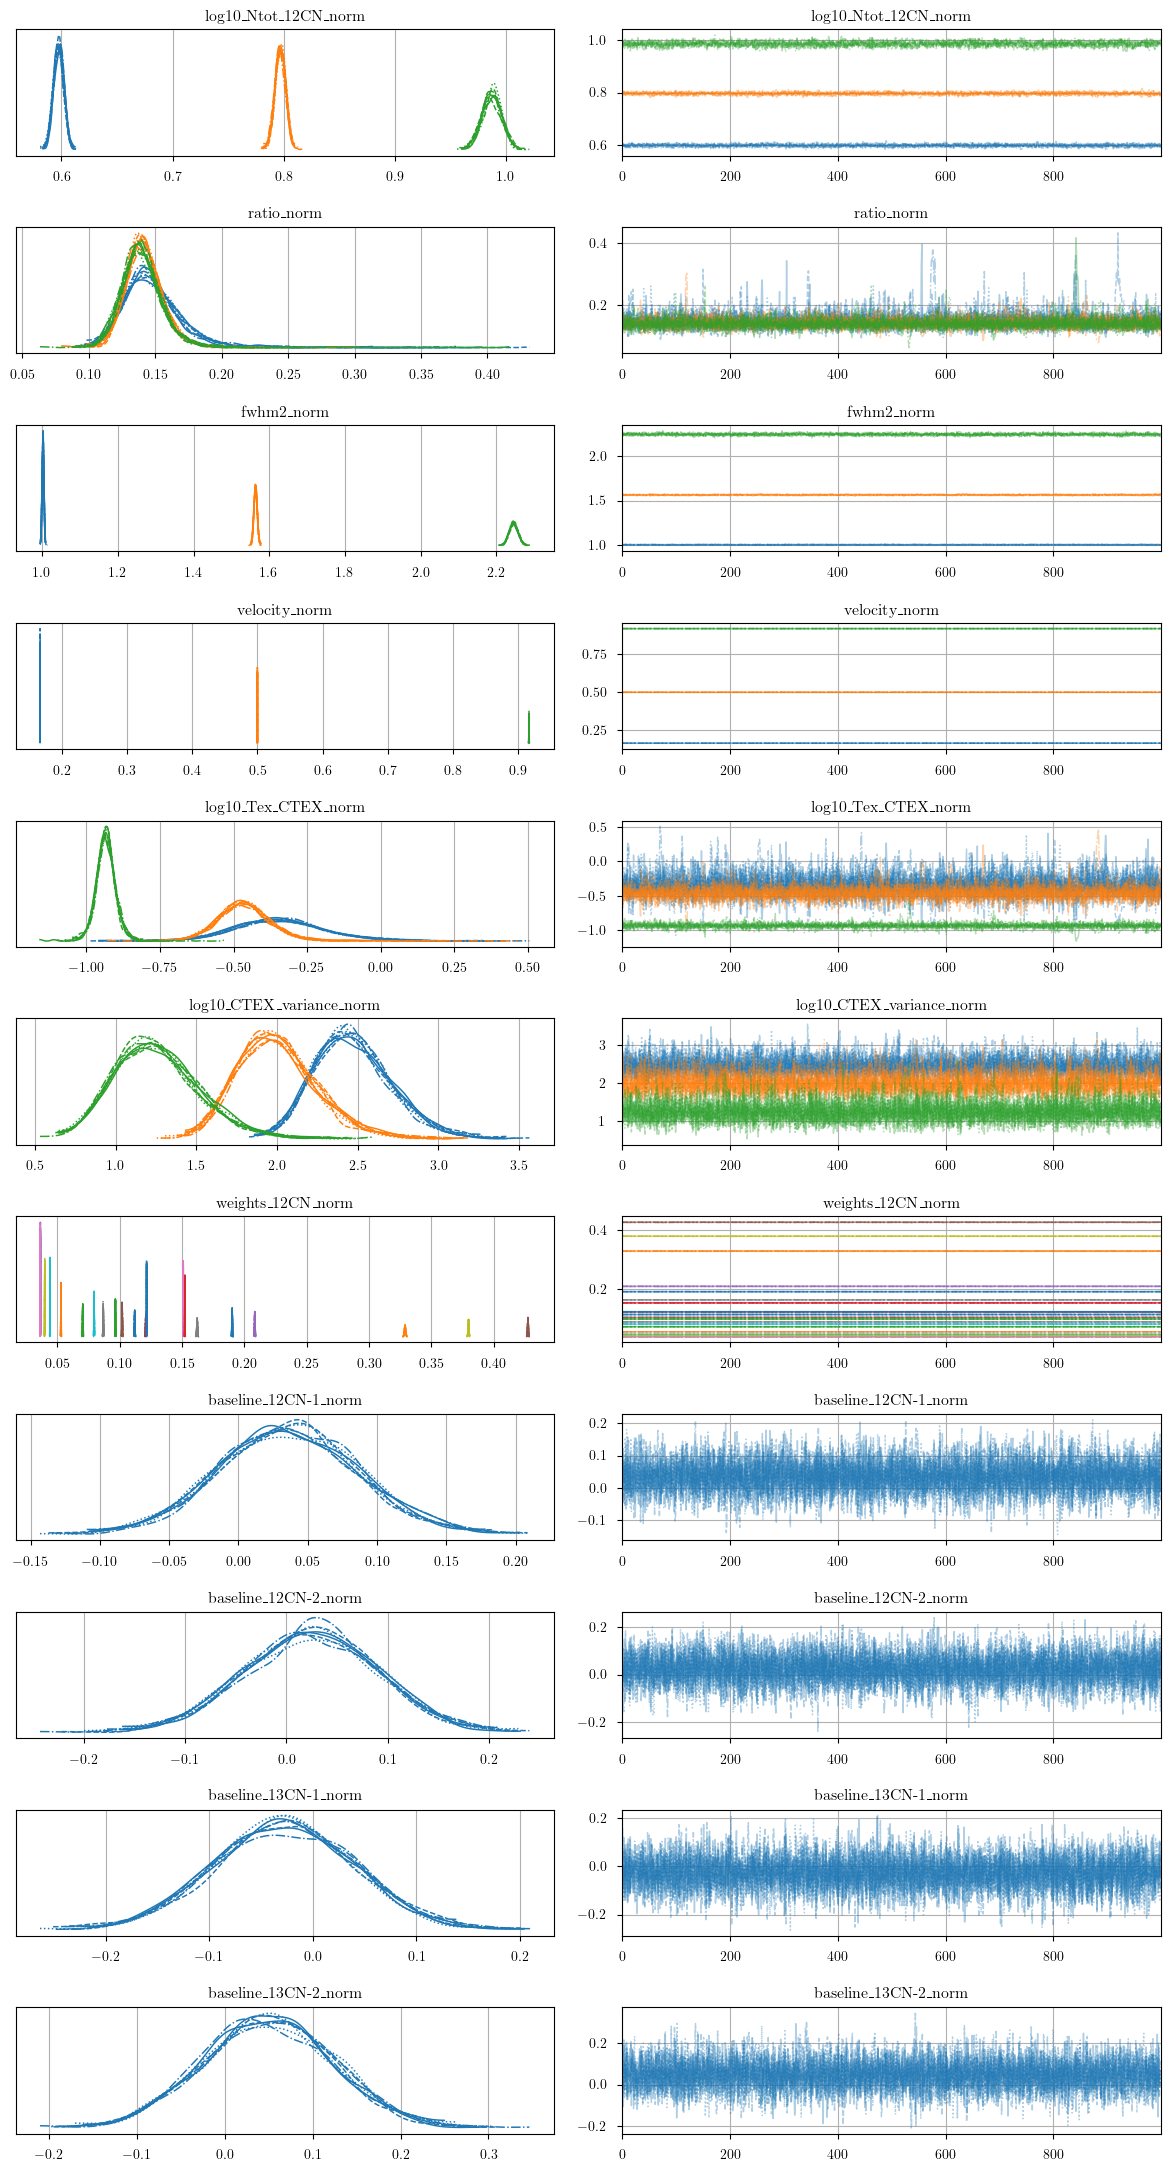

In [26]:
from bayes_spec.plots import plot_traces

axes = plot_traces(model.trace.posterior, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

['log10_Ntot_12CN_norm', 'ratio_norm', 'fwhm2_norm', 'velocity_norm', 'log10_Tex_CTEX_norm', 'log10_CTEX_variance_norm']


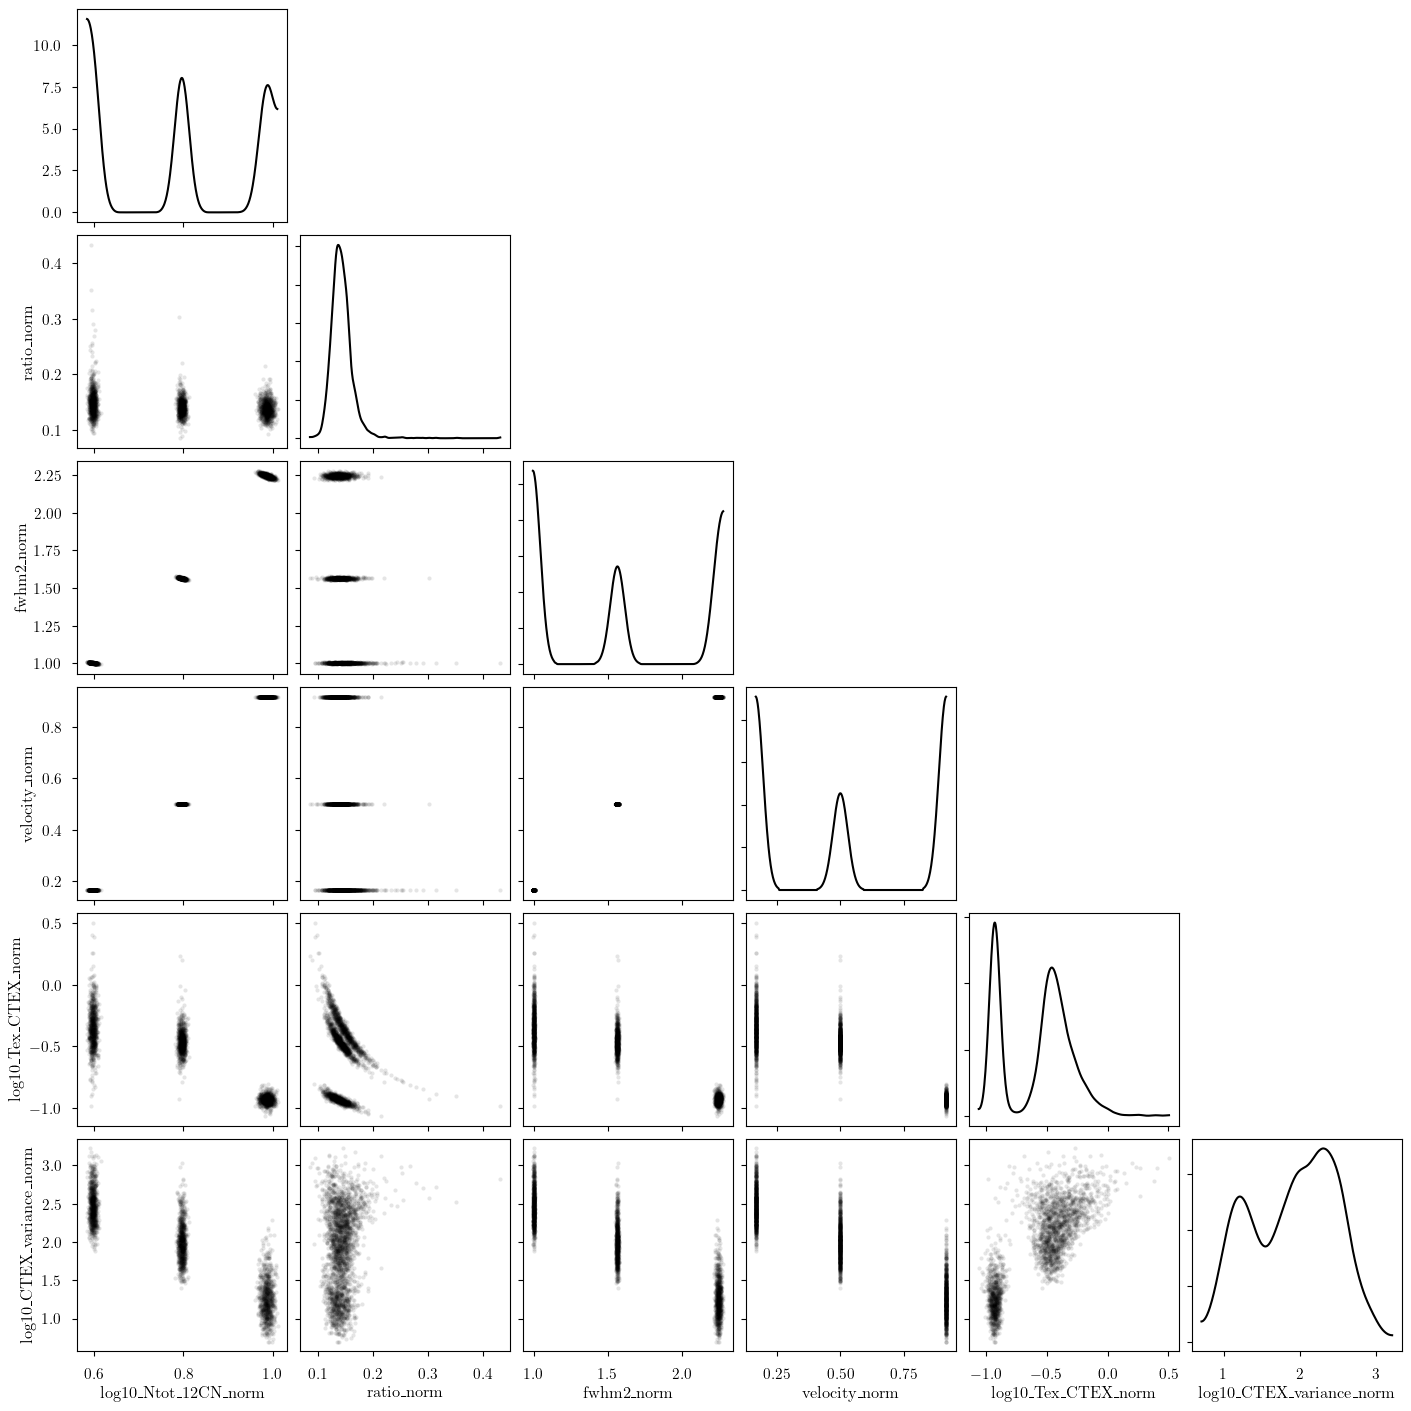

In [27]:
var_names = [
    param for param in model.cloud_freeRVs
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]))
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    combine_dims=["cloud"], # concatenate clouds
    kind="scatter", # plot type
)

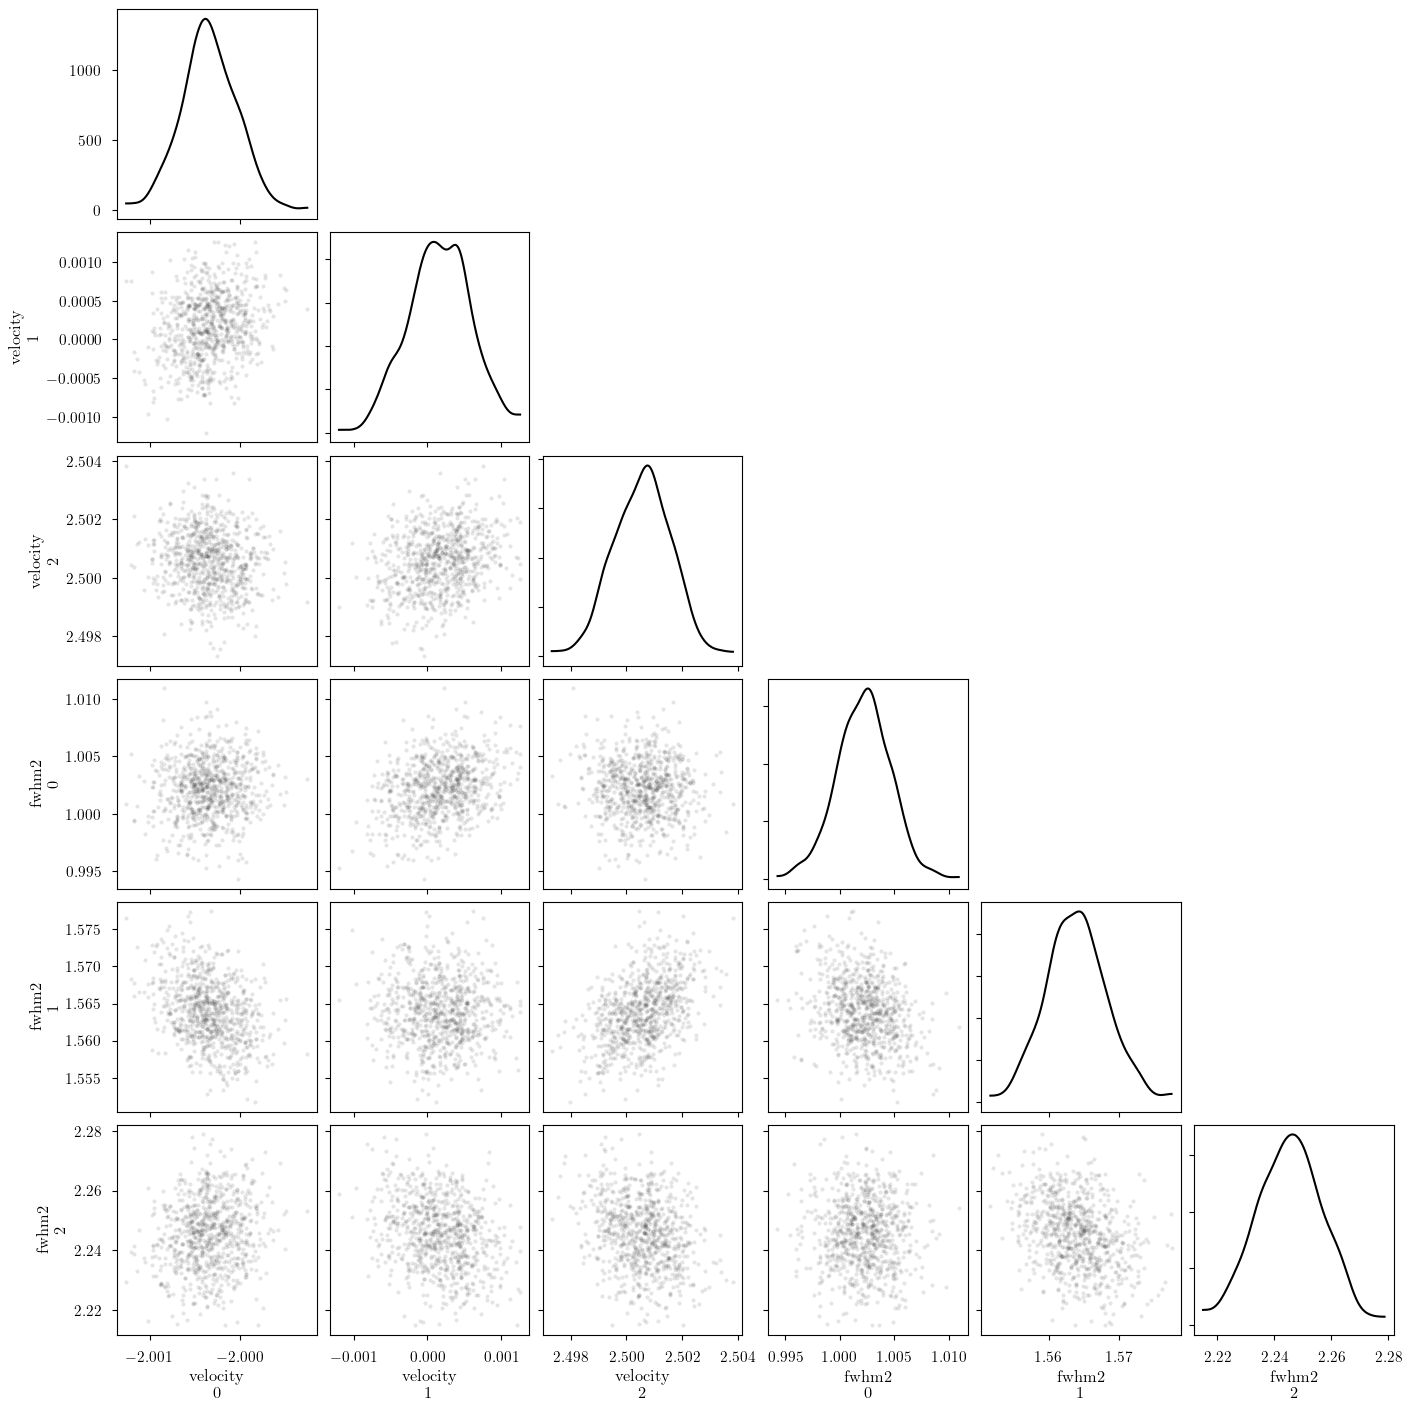

In [28]:
_ = plot_pair(
    model.trace.solution_0.sel(draw=slice(None, None, 10)), # samples
    ["velocity", "fwhm2"], # var_names to plot
    combine_dims=None, # do not concatenate clouds
    kind="scatter", # plot type
)

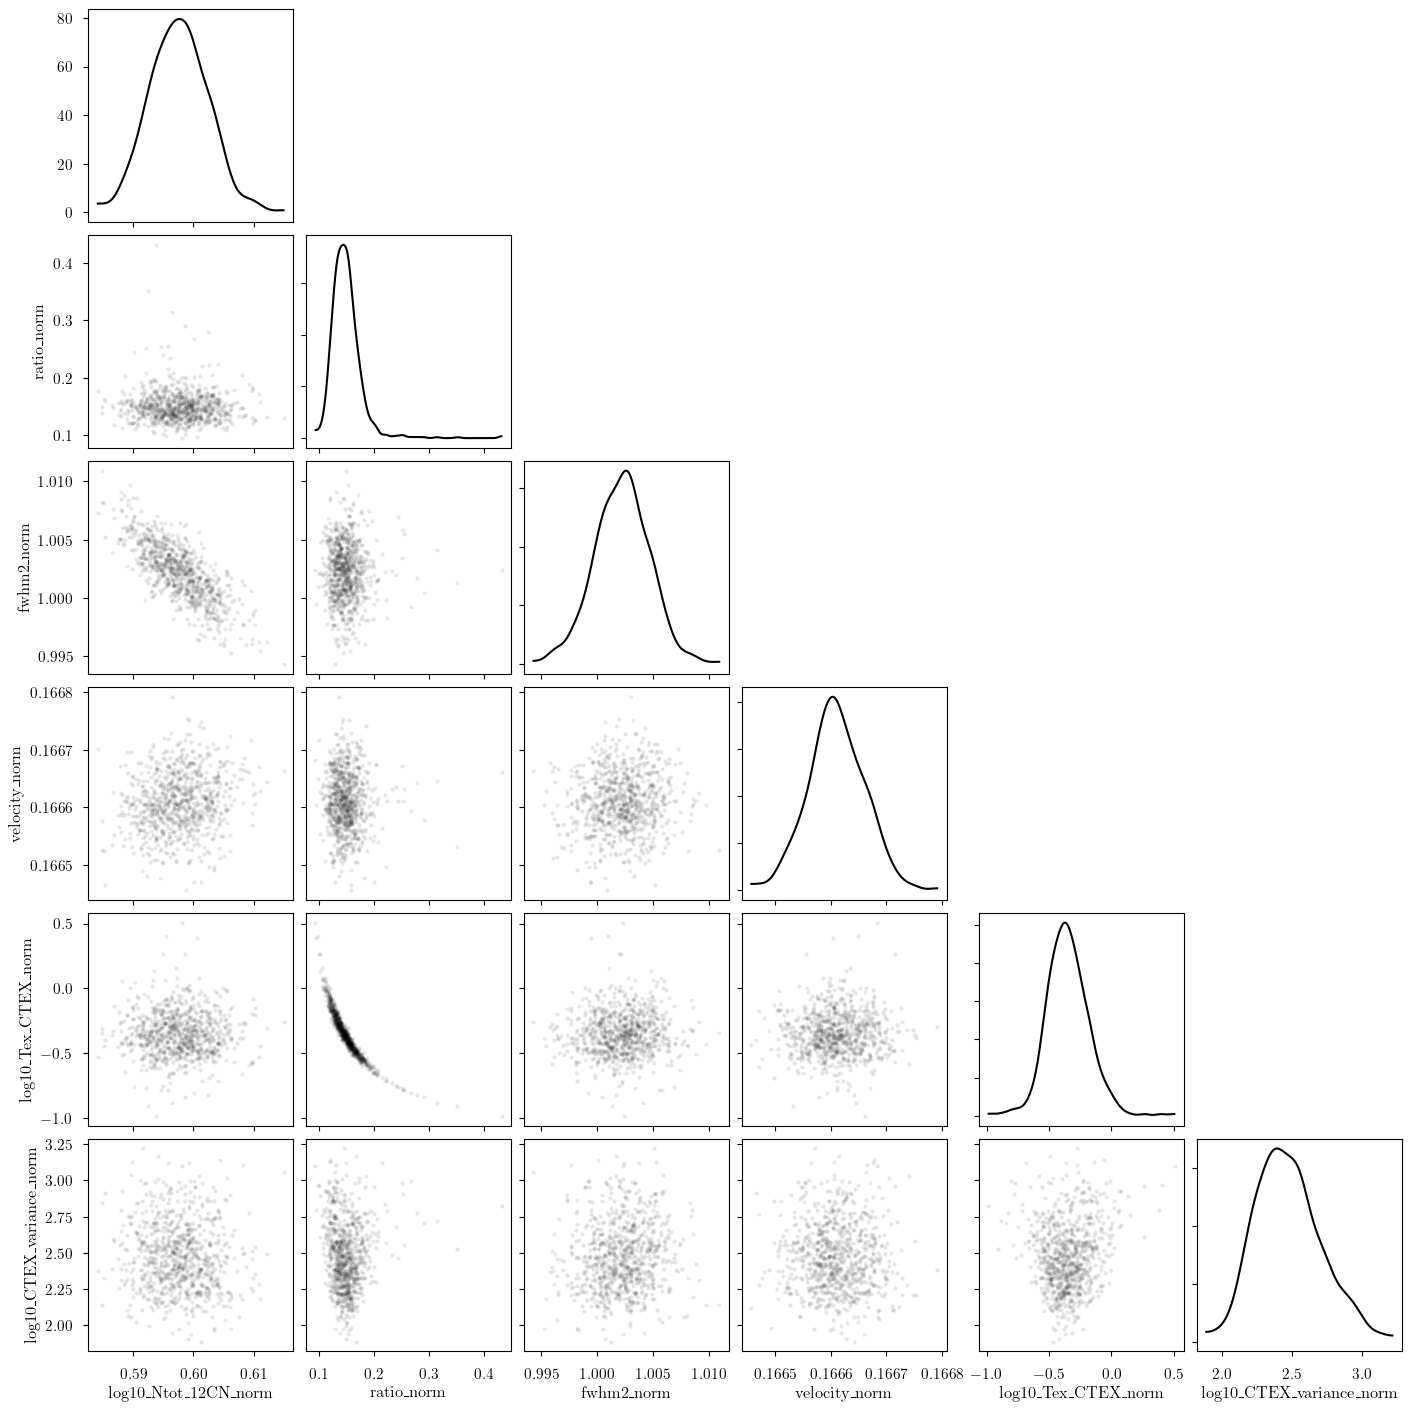

In [29]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    kind="scatter", # plot type
)

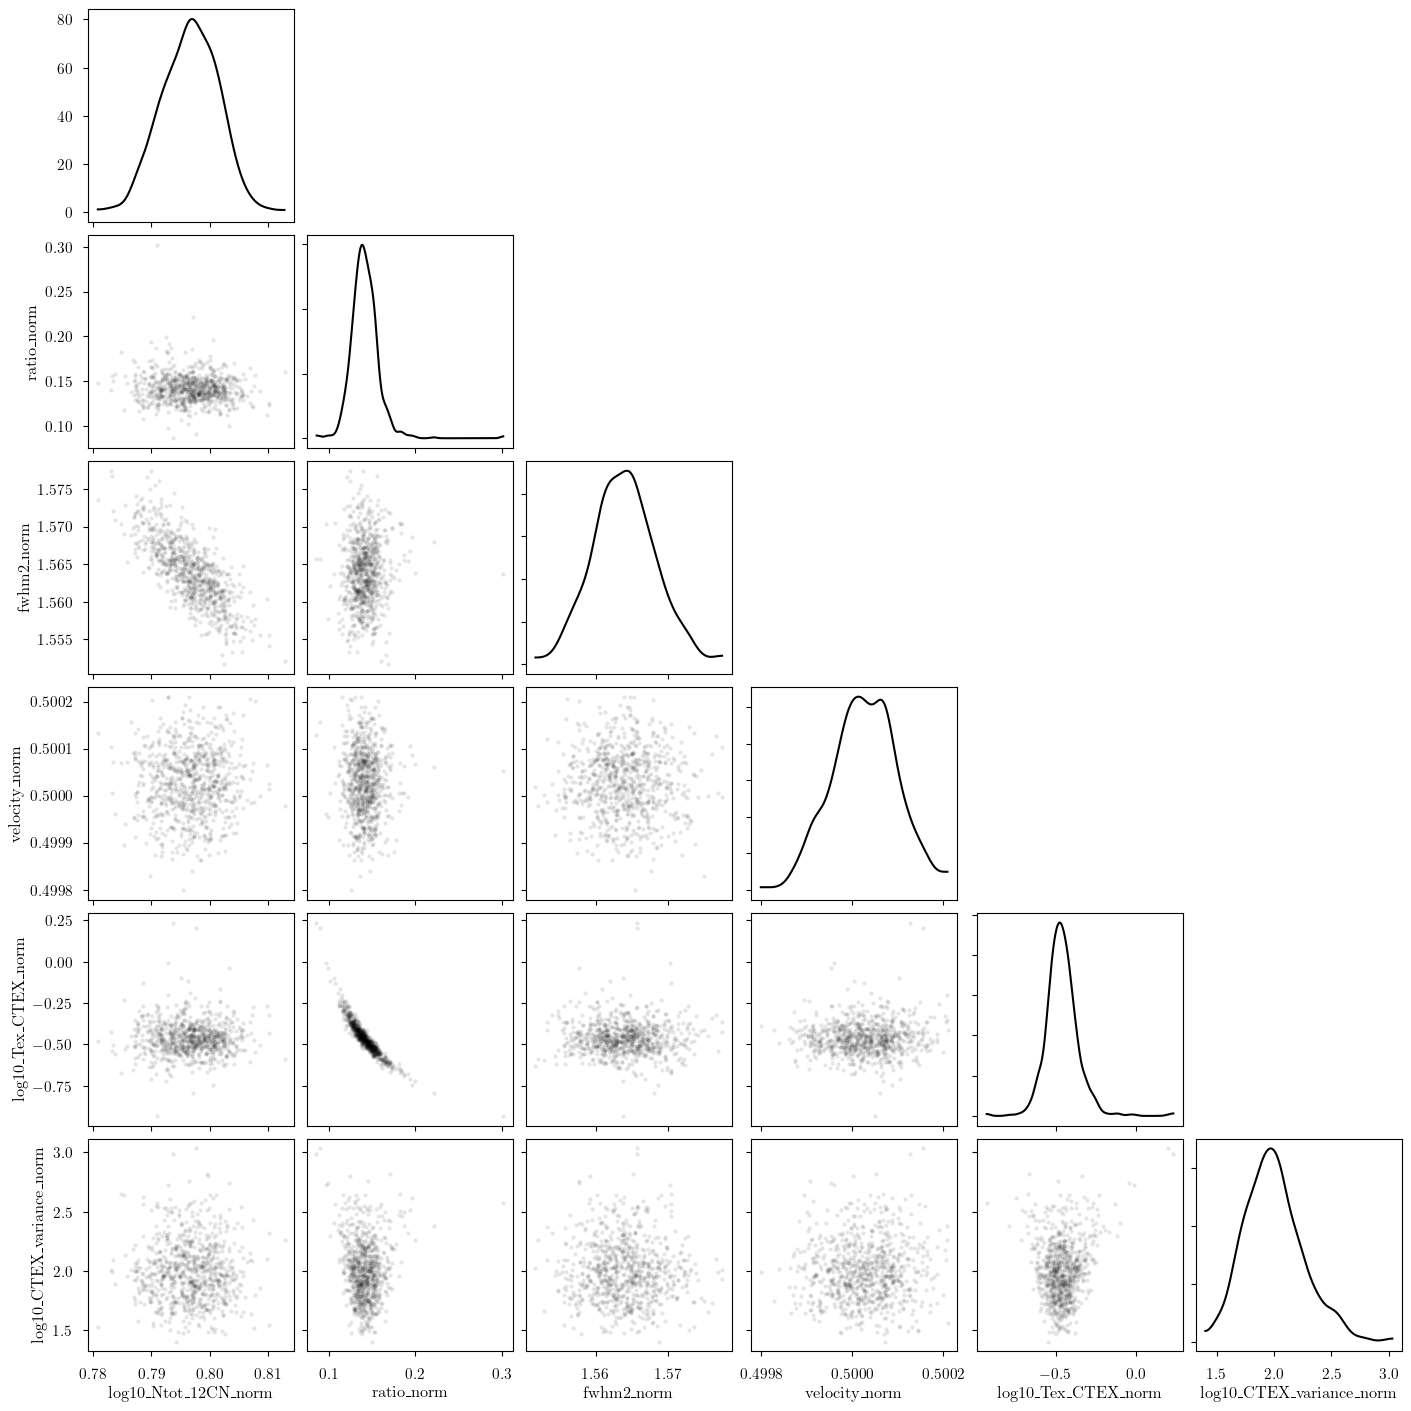

In [30]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    kind="scatter", # plot type
)

['log10_Ntot_12CN', 'ratio', 'fwhm2', 'velocity', 'log10_Tex_CTEX', 'log10_Ntot_13CN', 'log10_CTEX_variance', 'tau_total_12CN', 'Tex_13CN', 'tau_total_13CN']


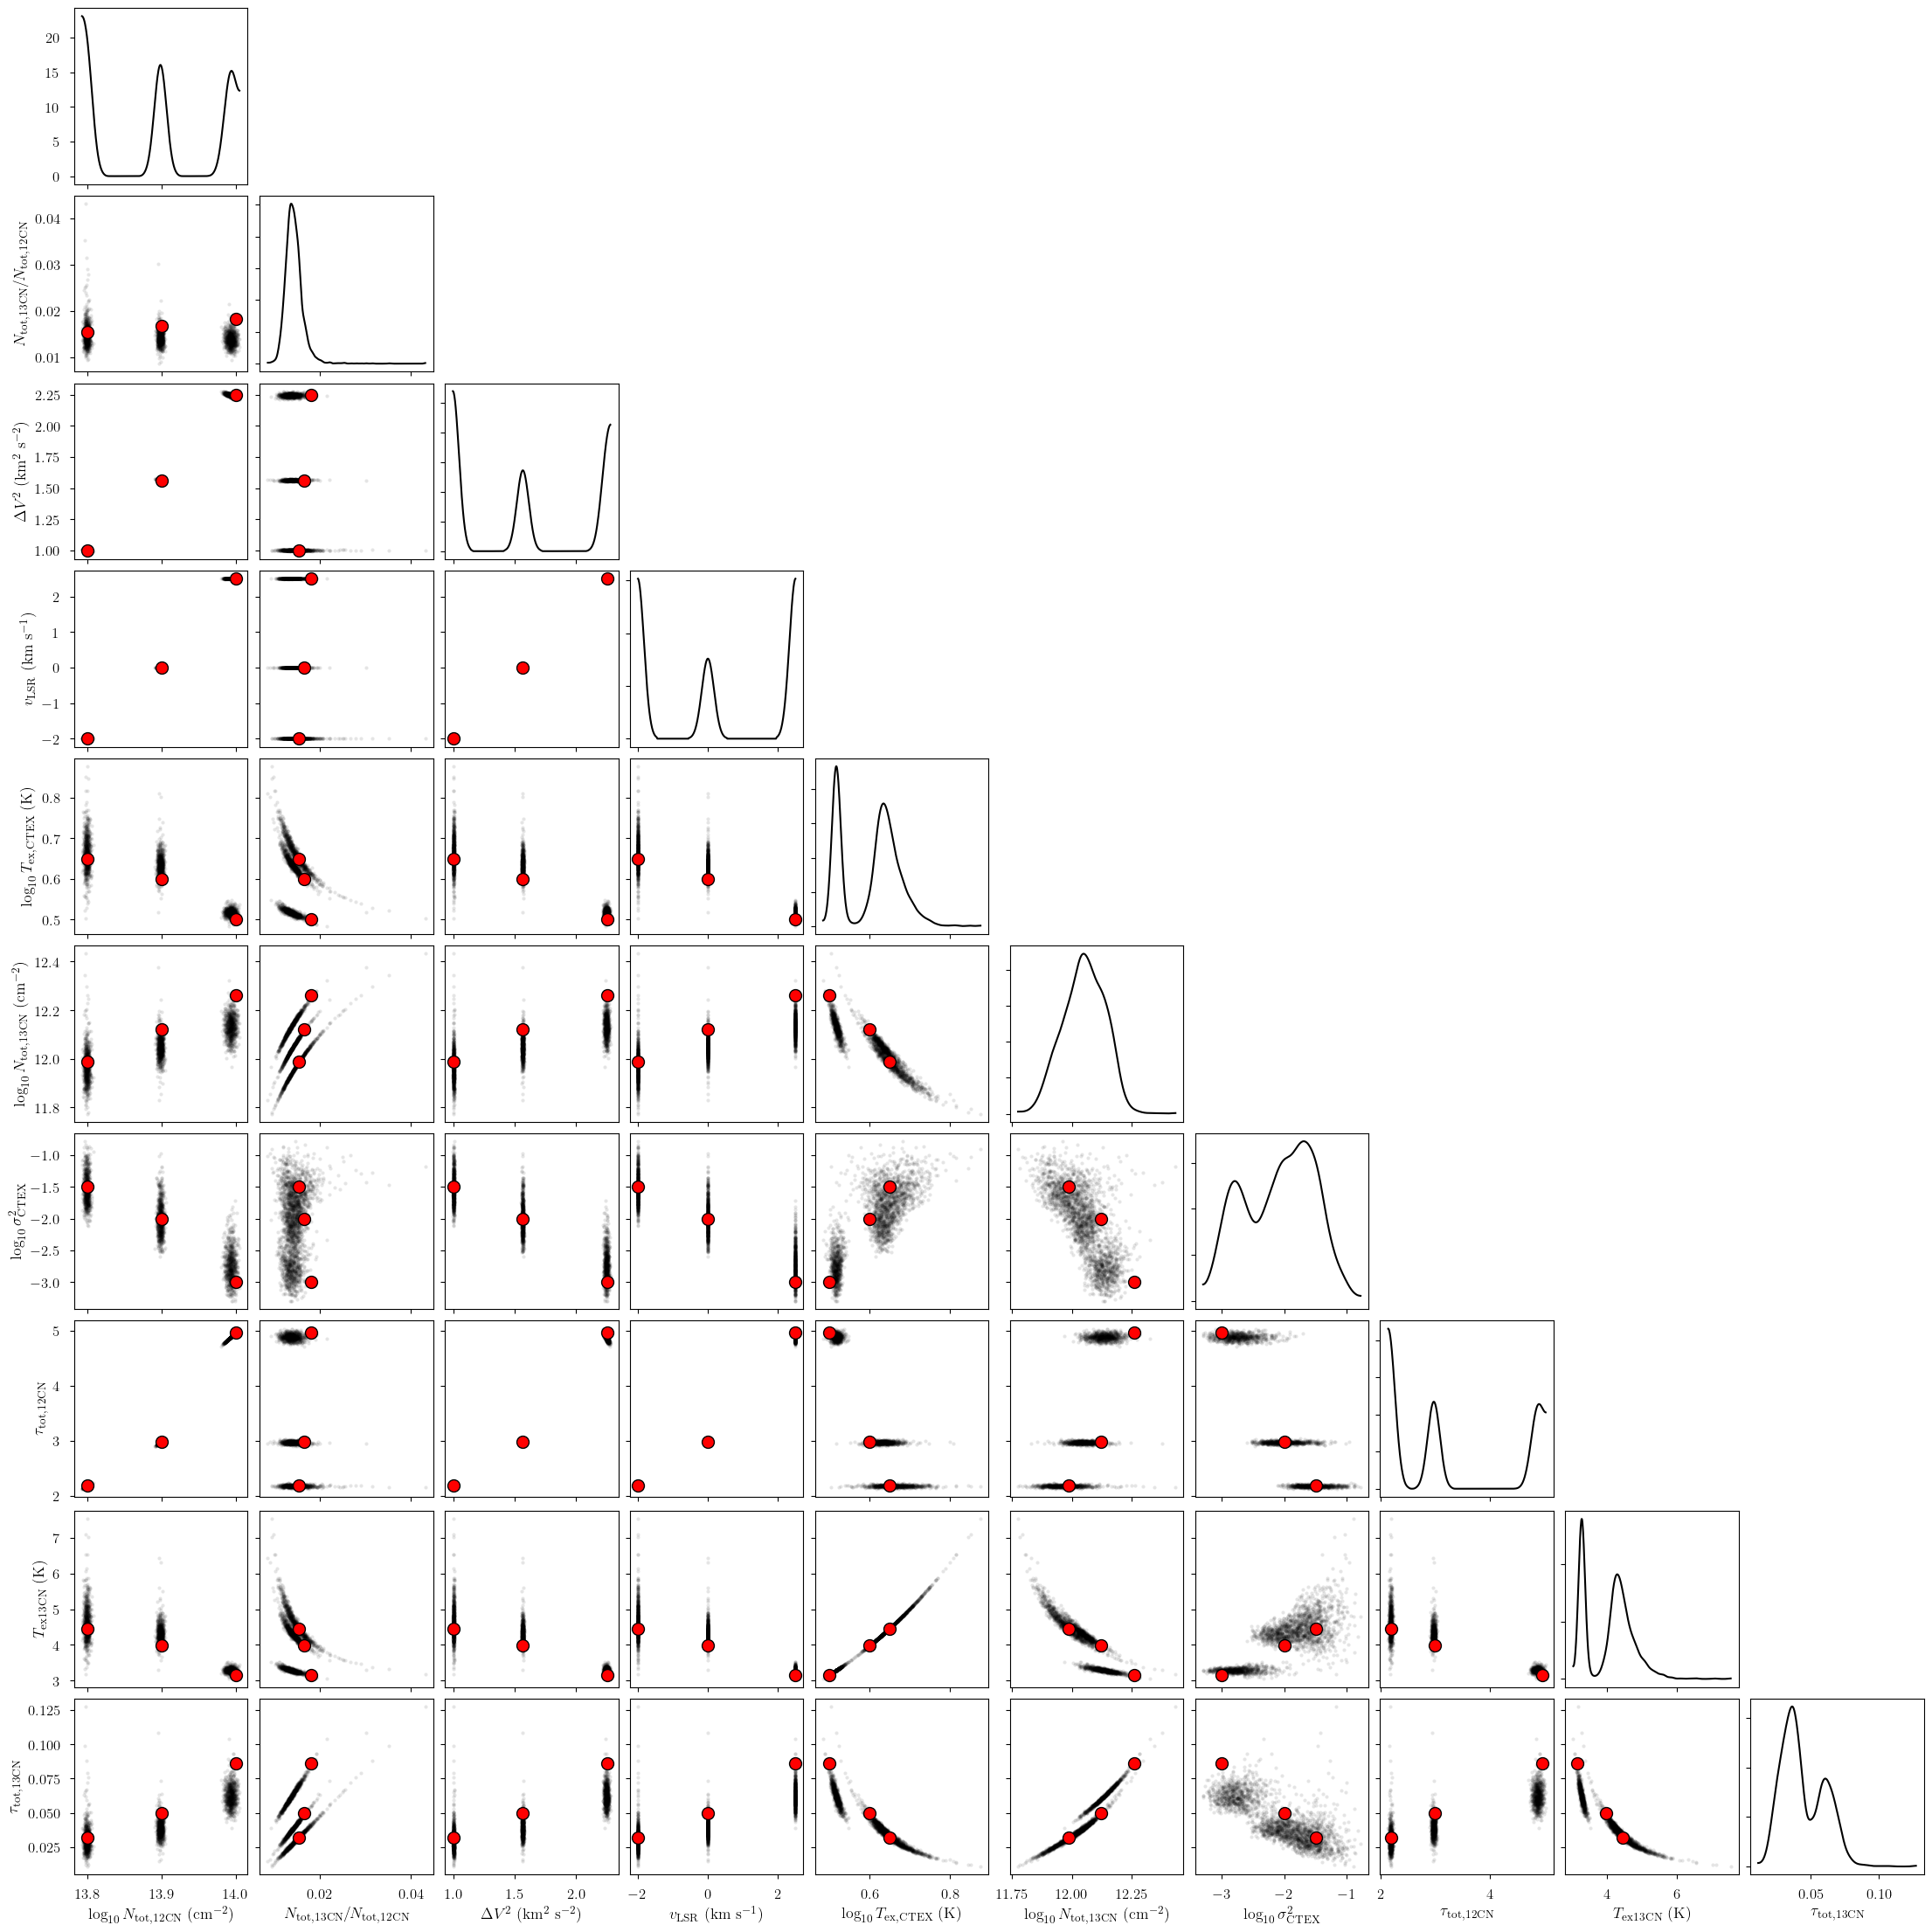

In [31]:
var_names = [
    param for param in model.cloud_deterministics + [p for p in model.cloud_freeRVs if "_norm" not in p]
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]))
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    combine_dims=["cloud"], # concatenate clouds
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=sim_params, # truths
)

In [32]:
# identify simulation cloud corresponding to each posterior cloud
sim_cloud_map = {}
for i in range(n_clouds):
    posterior_velocity = model.trace.solution_0['velocity'].sel(cloud=i).data.mean()
    match = np.argmin(np.abs(sim_params["velocity"] - posterior_velocity))
    sim_cloud_map[i] = match
sim_cloud_map

{0: np.int64(0), 1: np.int64(1), 2: np.int64(2)}

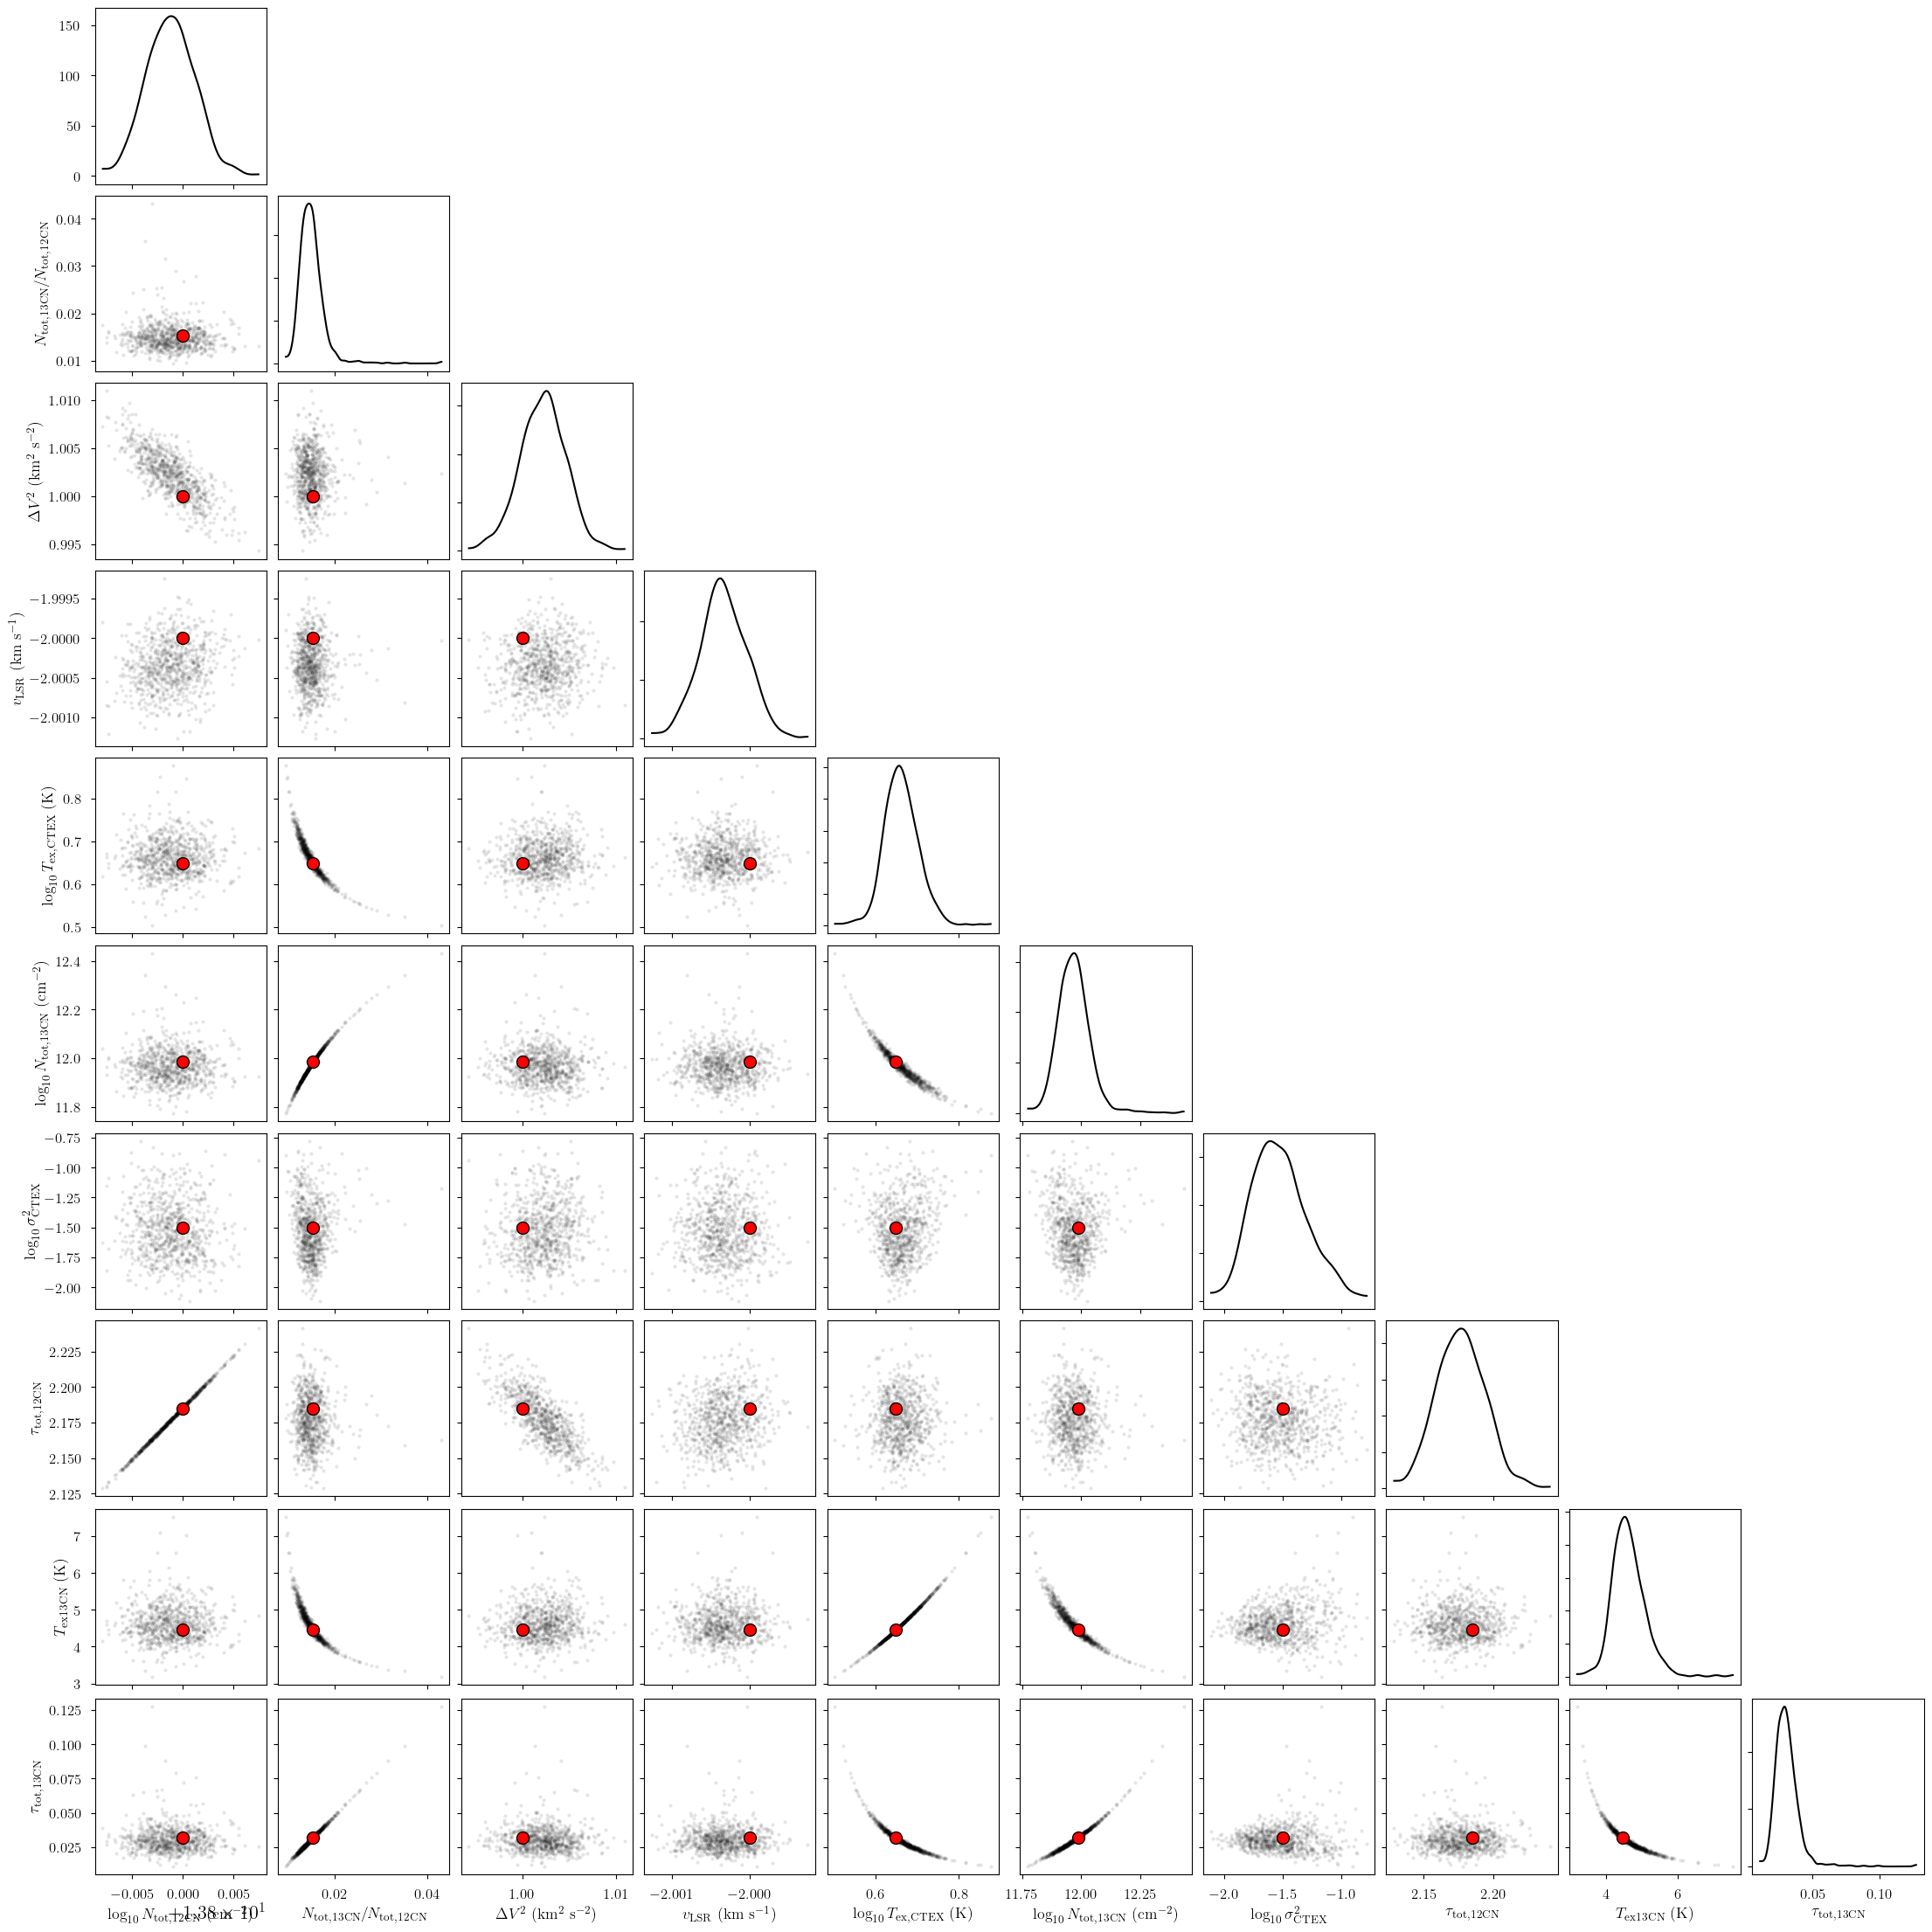

In [33]:
cloud = 0

# subset of sim_params
my_sim_params = {}
for var_name in var_names:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]

_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=my_sim_params, # truths
)

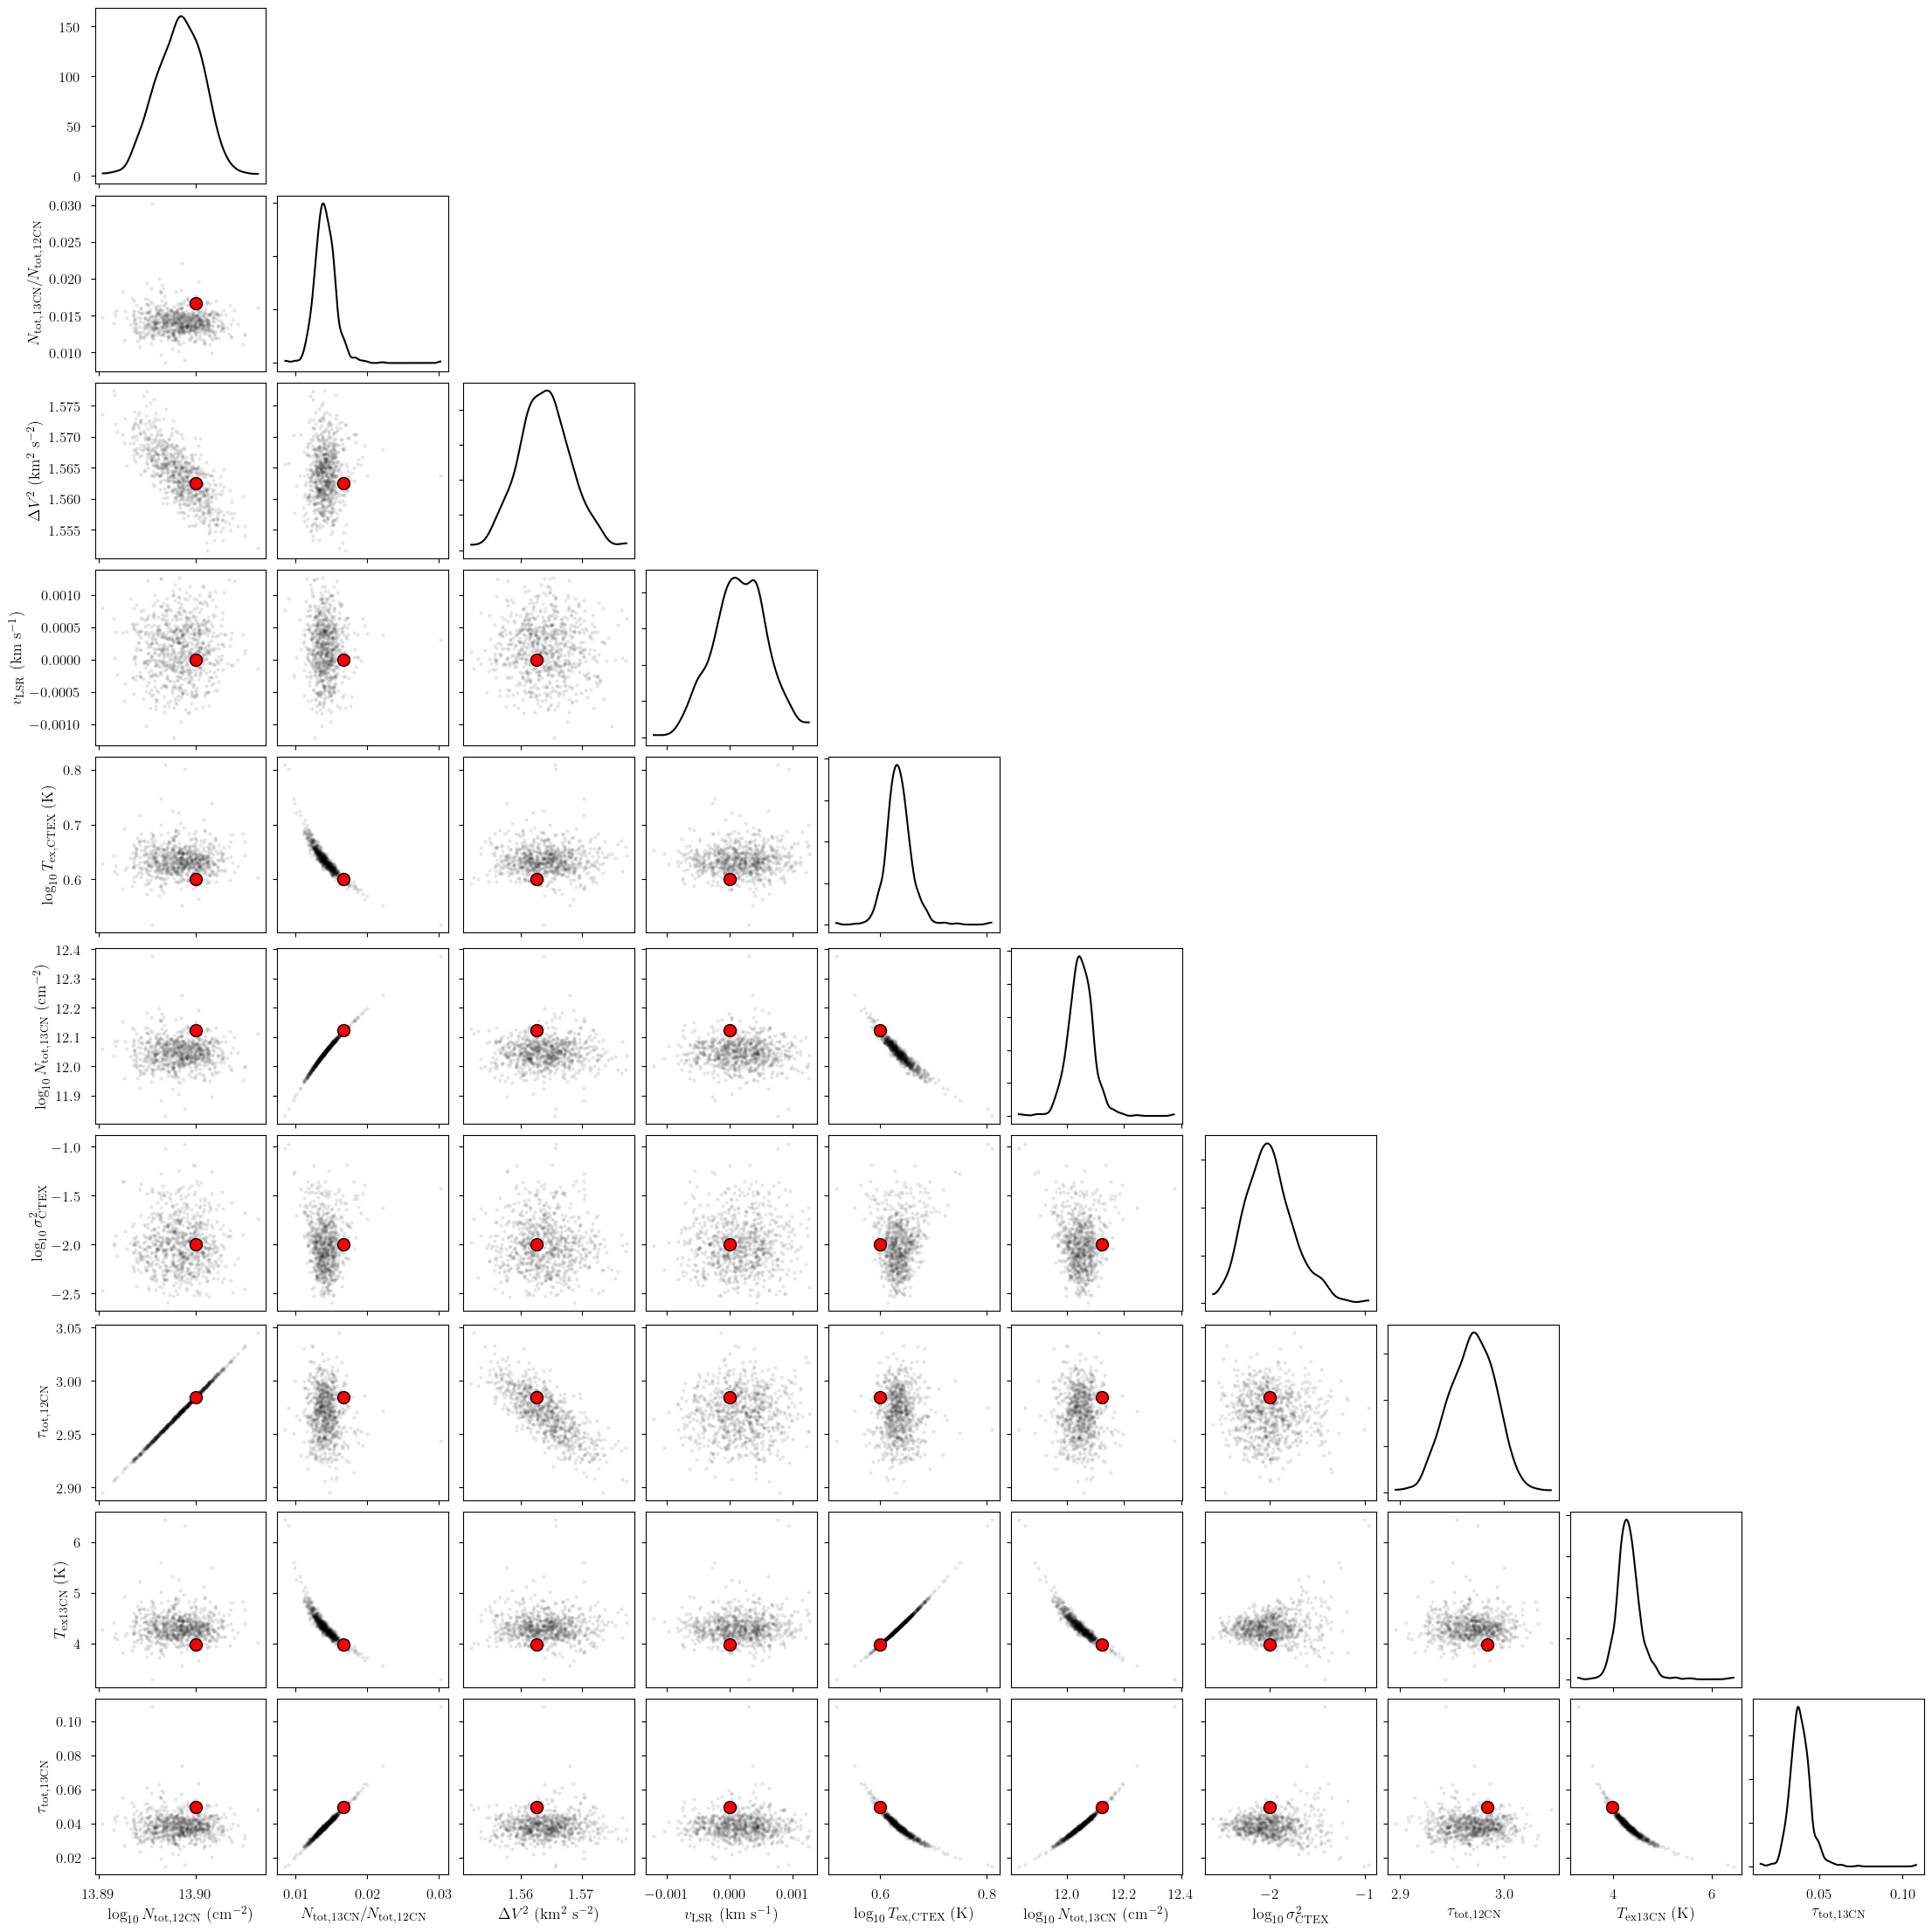

In [34]:
cloud = 1

# subset of sim_params
my_sim_params = {}
for var_name in var_names:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]

_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=my_sim_params, # truths
)

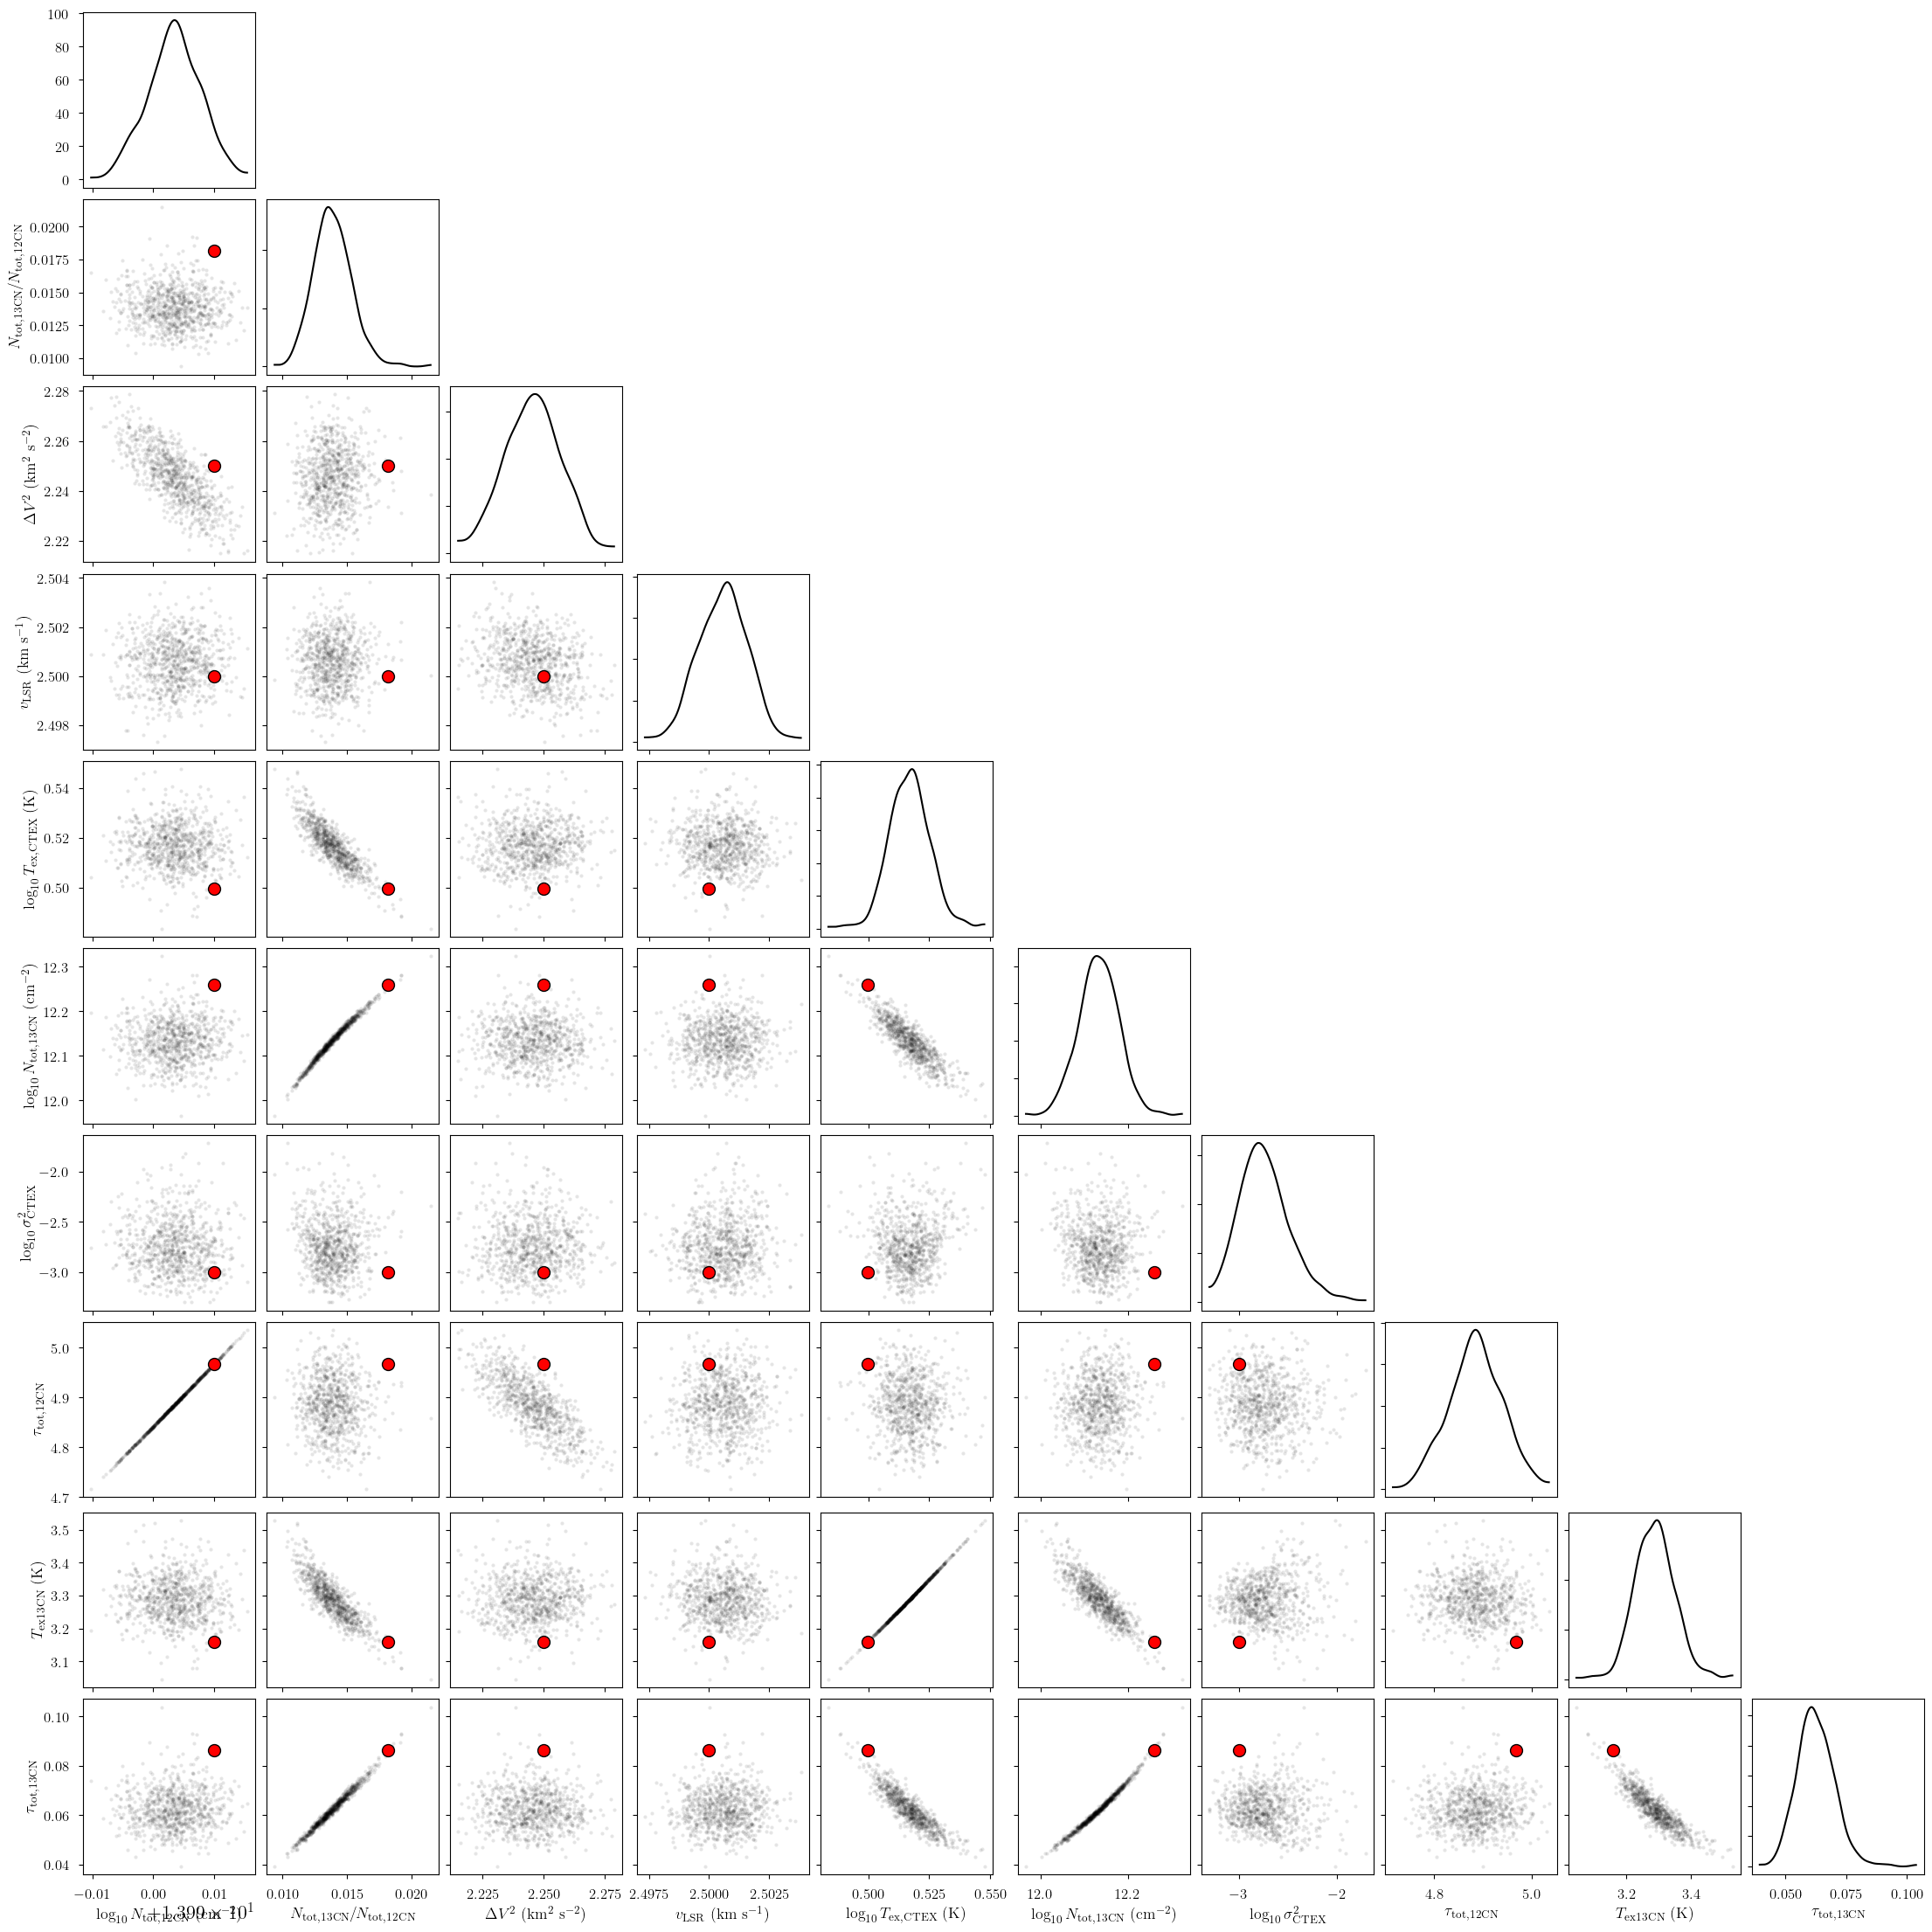

In [35]:
cloud = 2

# subset of sim_params
my_sim_params = {}
for var_name in var_names:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]

_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=my_sim_params, # truths
)

In [36]:
point_stats = az.summary(model.trace.solution_0, kind='stats')
print("BIC:", model.bic())
display(point_stats)

BIC: -12924.17555539098


mean     sd  hdi_3%  hdi_97%
baseline_12CN-1_norm[0]               0.036  0.050  -0.058    0.130
baseline_12CN-2_norm[0]               0.024  0.065  -0.098    0.145
baseline_13CN-1_norm[0]              -0.028  0.067  -0.156    0.096
baseline_13CN-2_norm[0]               0.050  0.074  -0.089    0.186
log10_Ntot_12CN_norm[0]               0.597  0.005   0.588    0.606
log10_Ntot_12CN_norm[1]               0.797  0.005   0.788    0.805
log10_Ntot_12CN_norm[2]               0.987  0.009   0.971    1.003
log10_Tex_CTEX_norm[0]               -0.342  0.163  -0.644   -0.030
log10_Tex_CTEX_norm[1]               -0.463  0.095  -0.633   -0.286
log10_Tex_CTEX_norm[2]               -0.934  0.034  -0.999   -0.872
ratio_norm[0]                         0.148  0.024   0.112    0.192
ratio_norm[1]                         0.142  0.015   0.115    0.168
ratio_norm[2]                         0.140  0.016   0.111    0.168
fwhm2_norm[0]                         1.002  0.002   0.998    1.007
fwhm2_norm[1]                         1.564  0.004   1.555    1.572
fwhm2_norm[2]                         2.246  0.011   2.226    2.267
velocity_norm[0]                      0.167  0.000   0.167    0.167
velocity_norm[1]                      0.500  0.000   0.500    0.500
velocity_norm[2]                      0.917  0.000   0.916    0.917
log10_CTEX_variance_norm[0]           2.472  0.237   2.033    2.914
log10_CTEX_variance_norm[1]           1.999  0.247   1.558    2.466
log10_CTEX_variance_norm[2]           1.255  0.266   0.782    1.751
weights_12CN_norm[0, 0 0 1 1 -- --]   0.190  0.000   0.190    0.191
weights_12CN_norm[0, 0 0 1 2 -- --]   0.329  0.001   0.328    0.330
weights_12CN_norm[0, 1 0 1 1 -- --]   0.070  0.000   0.070    0.071
weights_12CN_norm[0, 1 0 1 2 -- --]   0.121  0.000   0.121    0.121
weights_12CN_norm[0, 1 0 2 1 -- --]   0.036  0.000   0.036    0.037
weights_12CN_norm[0, 1 0 2 2 -- --]   0.102  0.000   0.102    0.102
weights_12CN_norm[0, 1 0 2 3 -- --]   0.151  0.000   0.151    0.151
weights_12CN_norm[1, 0 0 1 1 -- --]   0.162  0.000   0.162    0.163
weights_12CN_norm[1, 0 0 1 2 -- --]   0.380  0.000   0.379    0.380
weights_12CN_norm[1, 1 0 1 1 -- --]   0.044  0.000   0.044    0.044
weights_12CN_norm[1, 1 0 1 2 -- --]   0.112  0.000   0.112    0.112
weights_12CN_norm[1, 1 0 2 1 -- --]   0.053  0.000   0.053    0.053
weights_12CN_norm[1, 1 0 2 2 -- --]   0.097  0.000   0.096    0.097
weights_12CN_norm[1, 1 0 2 3 -- --]   0.152  0.000   0.152    0.153
weights_12CN_norm[2, 0 0 1 1 -- --]   0.208  0.000   0.208    0.209
weights_12CN_norm[2, 0 0 1 2 -- --]   0.427  0.000   0.427    0.428
weights_12CN_norm[2, 1 0 1 1 -- --]   0.036  0.000   0.036    0.036
weights_12CN_norm[2, 1 0 1 2 -- --]   0.087  0.000   0.087    0.087
weights_12CN_norm[2, 1 0 2 1 -- --]   0.040  0.000   0.040    0.040
weights_12CN_norm[2, 1 0 2 2 -- --]   0.079  0.000   0.079    0.080
weights_12CN_norm[2, 1 0 2 3 -- --]   0.122  0.000   0.121    0.122
log10_Ntot_12CN[0]                   13.799  0.002  13.794   13.803
log10_Ntot_12CN[1]                   13.898  0.002  13.894   13.903
log10_Ntot_12CN[2]                   13.993  0.004  13.985   14.002
ratio[0]                              0.015  0.002   0.011    0.019
ratio[1]                              0.014  0.001   0.012    0.017
ratio[2]                              0.014  0.002   0.011    0.017
fwhm2[0]                              1.002  0.002   0.998    1.007
fwhm2[1]                              1.564  0.004   1.555    1.572
fwhm2[2]                              2.246  0.011   2.226    2.267
velocity[0]                          -2.000  0.000  -2.001   -2.000
velocity[1]                           0.000  0.000  -0.001    0.001
velocity[2]                           2.501  0.001   2.499    2.502
log10_Tex_CTEX[0]                     0.664  0.041   0.589    0.743
log10_Tex_CTEX[1]                     0.634  0.024   0.592    0.678
log10_Tex_CTEX[2]                     0.516  0.009   0.500    0.532
log10_Ntot_13CN[0]         